In [0]:
#importing dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2

The class Inverted pendulum will help in the plotting of the system's position at various points in time. Basically we plot the figures at different time using this clas

In [0]:

class InvertedPendulum:
    def __init__(self):
        f = 0

    def step( self, state_vec, t=None ):
        """ state vector :
                x0 : position of the cart
                x1 : veclocity of the cart
                x2 : angle of pendulum. In ref frame with x as forward of the cart and y as up. Angile with respect to ground plane
                x3 : angular velocity of the pendulum
        """
        CART_POS = state_vec[0]
        BOB_ANG  = state_vec[2]*180. / np.pi # degrees
        LENGTH_OF_PENDULUM = 110.

        IM = np.zeros( (512, 512,3), dtype='uint8' )

        # Ground line
        cv2.line(IM, (0, 450), (IM.shape[1], 450), (19,69,139), 4 )


        # Mark ground line
        XSTART = -5.
        XEND = 5.
        for xd in np.linspace( XSTART, XEND, 11 ):
            x = int(   (xd - XSTART) / (XEND - XSTART) * IM.shape[0]   )

            cv2.circle( IM, (x, 450), 5, (0,255,0), -1 )

            cv2.putText(IM, str(xd), (x-15,450+15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1);


        # Draw Wheels of the cart
        wheel_1_pos = int(   (CART_POS - 1.2 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        wheel_2_pos = int(   (CART_POS + 1.2 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.circle( IM, (wheel_1_pos, 415), 25, (255,255,255), 6 )
        cv2.circle( IM, (wheel_2_pos, 415), 25, (255,255,255), 6 )
        cv2.circle( IM, (wheel_1_pos, 415), 2, (255,255,255), -1 )
        cv2.circle( IM, (wheel_2_pos, 415), 2, (255,255,255), -1 )

        # Cart base
        cart_base_start = int(   (CART_POS - 2.5 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        cart_base_end   = int(   (CART_POS + 2.5 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.line( IM, (cart_base_start, 380), (cart_base_end, 380), (255,255,255), 6 )

        # Pendulum hinge
        pendulum_hinge_x = int(   (CART_POS - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        pendulum_hinge_y = 380
        cv2.circle( IM, (pendulum_hinge_x, pendulum_hinge_y), 10, (255,255,255), -1 )


        # Pendulum
        pendulum_bob_x = int( LENGTH_OF_PENDULUM * np.cos( BOB_ANG / 180. * np.pi ) )
        pendulum_bob_y = int( LENGTH_OF_PENDULUM * np.sin( BOB_ANG / 180. * np.pi ) )
        cv2.circle( IM, (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), 10, (255,255,255), -1 )
        cv2.line( IM, (pendulum_hinge_x, pendulum_hinge_y), (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), (255,255,255), 3 )

        # Mark the current angle
        angle_display = BOB_ANG % 360
        if( angle_display > 180 ):
            angle_display = -360+angle_display
        cv2.putText(IM, "theta="+str( np.round(angle_display,4) )+" deg", (pendulum_hinge_x-15, pendulum_hinge_y-15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1);


        # Display on top
        if t is not None:
            cv2.putText(IM, "t="+str(np.round(t,4))+"sec", (15, 15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1);
            cv2.putText(IM, "ANG="+str(np.round(BOB_ANG,4))+" degrees", (15, 35), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1);
            cv2.putText(IM, "POS="+str(np.round(CART_POS,4))+" m", (15, 55), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1);



        return IM


In [10]:
#We install some other dependencies
!pip install control
!pip install slycot
import numpy as np
import cv2

from scipy.integrate import solve_ivp
import control
import code
import time

The following block of code is where we perform the most important operations.
We write the linearized equation of state space variable describing our system.
We also cook up the desired eigenvalues using LQR, find K and u.

We use small arbitrary values for the damping terms.

In [11]:

class MyLinearizedSystem:
    def __init__(self):
        g = 9.8
        L = 1.5
        m = 1.0
        M = 5.0
        d1 = 1.0
        d2 = 0.5

        # Pendulum up (linearized eq)
        # Eigen val of A : array([[ 1.        , -0.70710678, -0.07641631,  0.09212131] )
        _q = (m+M) * g / (M*L)
        self.A = np.array([
                    [0,1,0,0],
                    [0,-d1, -g*m/M,0],
                    [0,0,0,1.],
                    [0,d1/L,_q,-d2] ] )

        self.B = np.expand_dims( np.array( [0, 1.0/M, 0., -1/(M*L)] ) , 1 ) # 4x1

    def compute_K(self, desired_eigs = [-0.1, -0.2, -0.3, -0.4] ):
        print ('[compute_K] desired_eigs=', desired_eigs)
        self.K = control.place( self.A, self.B,  desired_eigs )

    def get_K(self):
        return self.K


# Global Variables
ss = MyLinearizedSystem()

# Arbitrarily set Eigen Values
#ss.compute_K(desired_eigs = np.array([-.1, -.2, -.3, -.4])*3. ) # Arbitarily set desired eigen values

# Eigen Values set by LQR
Q = np.diag( [1,1,1,1.] )
R = np.diag( [1.] )
# K : State feedback for stavility
# S : Solution to Riccati Equation
# E : Eigen values of the closed loop system
K, S, E = control.lqr( ss.A, ss.B, Q, R )
ss.compute_K(desired_eigs = E ) # Arbitarily set desired eigen values



# This will be our LQR Controller.
# LQRs are more theoritically grounded, they are a class of optimal control algorithms.
# The control law is u = KY. K is the unknown which is computed as a solution to minimization problem.
def u( t , y ):
    u_ = -np.matmul( ss.get_K() , y-np.array([0,0,np.pi/2.,0]) ) # This was important
    print ('u()', 't=',t, 'u_=', u_)
    # code.interact(local=dict(globals(), **locals()))
    # return 0.1
    return u_[0]

# Pendulum and cart system (non-linear eq). The motors on the cart turned at fixed time. In other words
# The motors are actuated to deliver forward x force from t=t1 to t=t2.
# Y : [ x, x_dot, theta, theta_dot]
# Return dot(Y)
def y_dot( t, y ):
    g = 9.8 # Gravitational Acceleration
    L = 1.5 # Length of pendulum

    m = 1.0 #mass of bob (kg)
    M = 5.0  # mass of cart (kg)

    d1 = 1.0
    d2 = 0.5


    x_ddot = u(t, y) - m*L*y[3]*y[3] * np.cos( y[2] ) + m*g*np.cos(y[2]) *  np.sin(y[2])
    x_ddot = x_ddot / ( M+m-m* np.sin(y[2])* np.sin(y[2]) )

    theta_ddot = -g/L * np.cos( y[2] ) -  np.sin( y[2] ) / L * x_ddot


    damping_x =  - d1*y[1]
    damping_theta =  - d2*y[3]

    return [ y[1], x_ddot + damping_x, y[3], theta_ddot + damping_theta ]


[compute_K] desired_eigs= [-3.175091  +0.j -2.4888322 +0.j -0.81949747+0.j -0.20177409+0.j]


In the following block of code, we split the time interval 0 to 20 in 100 parts.

Using the solve_ivp function we can find the actuation term u at each of these time intervals depending upon our state space system.

In [12]:
sol = solve_ivp(y_dot, [0, 20], [ 0.0, 0., np.pi/2 + 0.01, 0. ],   t_eval=np.linspace( 0, 20, 100))

u() t= 0.0 u_= [[1.69417376]]
u() t= 2.841946949302222e-05 u_= [[1.69404411]]
u() t= 0.0005683893898604445 u_= [[1.69158075]]
u() t= 0.0008525840847906665 u_= [[1.69028401]]
u() t= 0.002273557559441778 u_= [[1.68380024]]
u() t= 0.0025261750660464195 u_= [[1.68264762]]
u() t= 0.002841946949302222 u_= [[1.68120655]]
u() t= 0.002841946949302222 u_= [[1.6812063]]
u() t= 0.008525840847906667 u_= [[1.65526697]]
u() t= 0.011367787797208886 u_= [[1.64227916]]
u() t= 0.025577522543719998 u_= [[1.57750421]]
u() t= 0.028103697609766415 u_= [[1.56616873]]
u() t= 0.03126141644232444 u_= [[1.5517541]]
u() t= 0.03126141644232444 u_= [[1.55149488]]
u() t= 0.06664701194913147 u_= [[1.39019685]]
u() t= 0.08433980970253499 u_= [[1.31074725]]
u() t= 0.17280379846955254 u_= [[0.95462878]]
u() t= 0.1885307298059112 u_= [[0.94025946]]
u() t= 0.20818939397635958 u_= [[0.86292515]]
u() t= 0.20818939397635958 u_= [[0.79273429]]
u() t= 0.2553664097206739 u_= [[0.61052419]]
u() t= 0.2789549175928311 u_= [[0.53492

In order to plot our results we need to make an object of InvertedPendulum() class.
We do that in the next code block.

In [0]:
syst = InvertedPendulum()

Upon execution of this block, we will get 100 images each corresponding to a point in time between 0 and 20 seconds. 

Each image has the time, position, velocity and angular velocity labelled which would help us to inspect the state of the system.

position    velocity    angle   angular velocity time
[0.0, 0.0, 1.5807963267948966, 0.0] 0.0


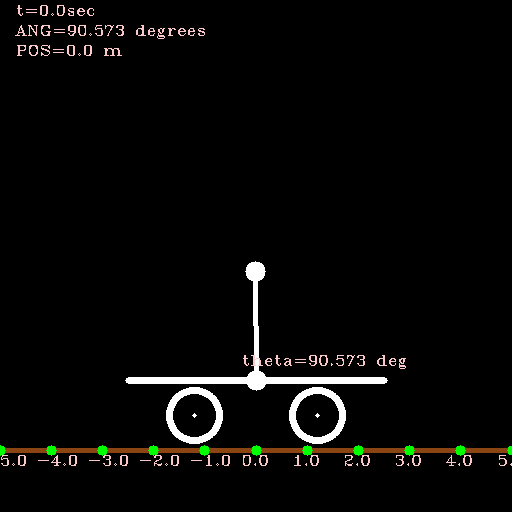

position    velocity    angle   angular velocity time
[0.004935022547545828, 0.04167578490467122, 1.5786254724065258, -0.017829564785597177] 0.20202020202020202


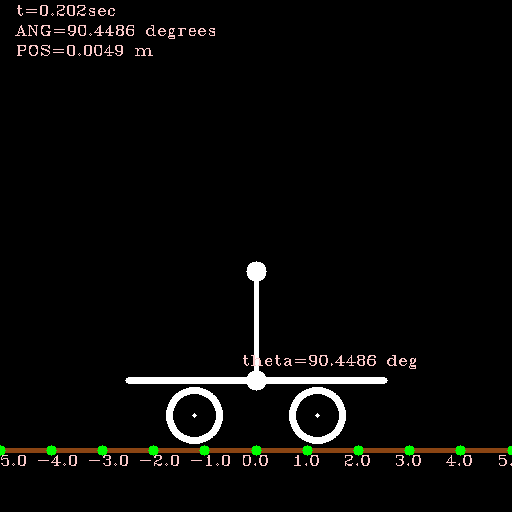

position    velocity    angle   angular velocity time
[0.014501589227728522, 0.048710584131476026, 1.57469866333373, -0.019165997732460652] 0.40404040404040403


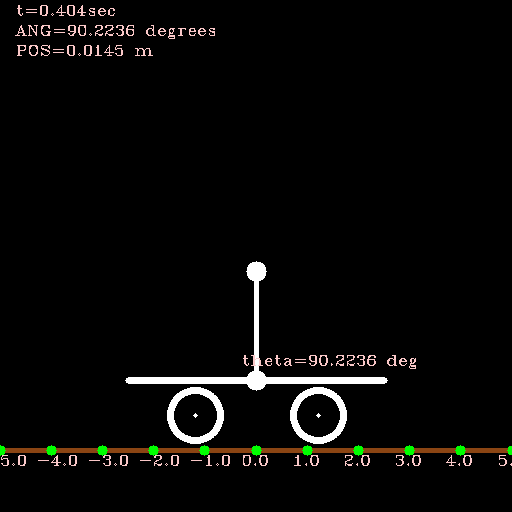

position    velocity    angle   angular velocity time
[0.02340929776363914, 0.037694302023496426, 1.5713613523283307, -0.013280857591111986] 0.6060606060606061


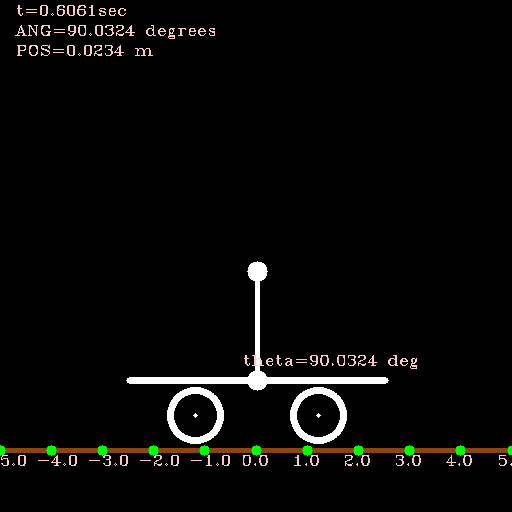

position    velocity    angle   angular velocity time
[0.029391133865613688, 0.021481285736167366, 1.56940933187532, -0.006187531894336704] 0.8080808080808081


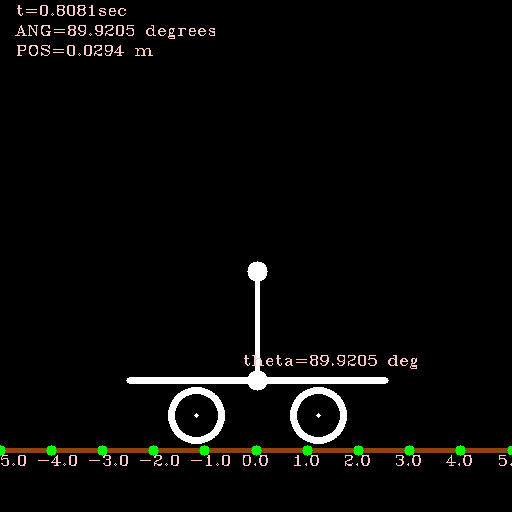

position    velocity    angle   angular velocity time
[0.032245026048386735, 0.0074750325576263335, 1.5687416097301048, -0.0008025140627312567] 1.0101010101010102


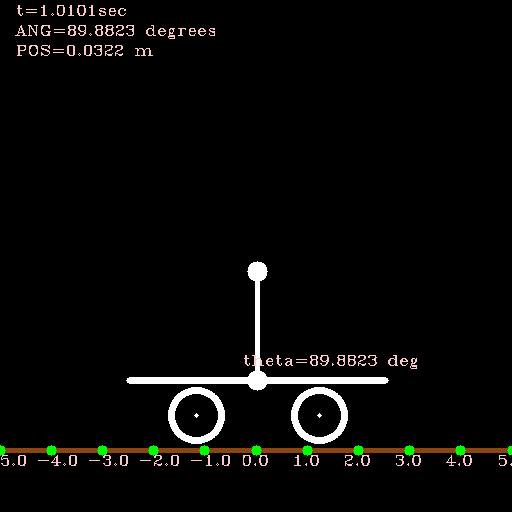

position    velocity    angle   angular velocity time
[0.03275577332464795, -0.001531404889005634, 1.568914026685841, 0.00211501424238924] 1.2121212121212122


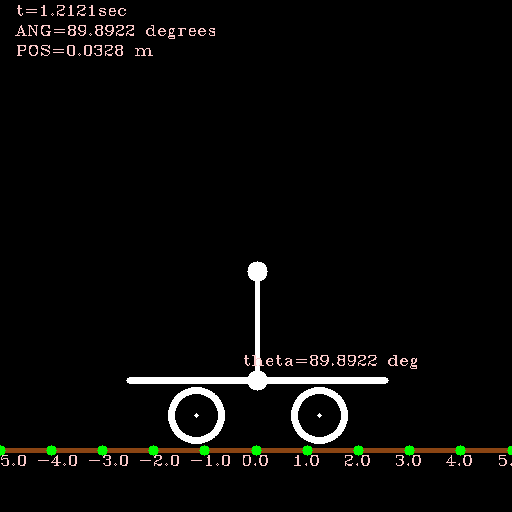

position    velocity    angle   angular velocity time
[0.031958888631739554, -0.005650014571452864, 1.5694560478175783, 0.002976206078567356] 1.4141414141414141


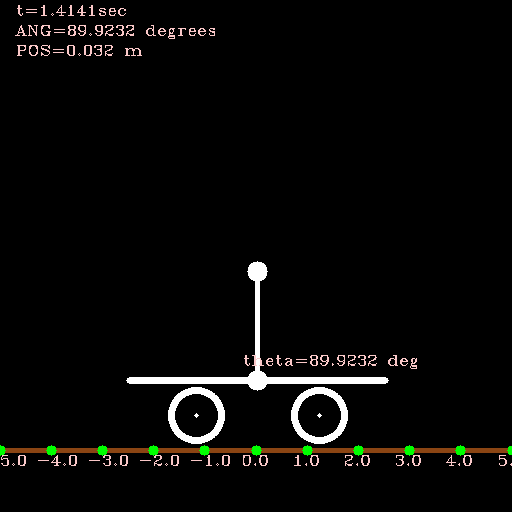

position    velocity    angle   angular velocity time
[0.03070669454477046, -0.0063217853502543055, 1.5700321650730493, 0.002590917562078251] 1.6161616161616161


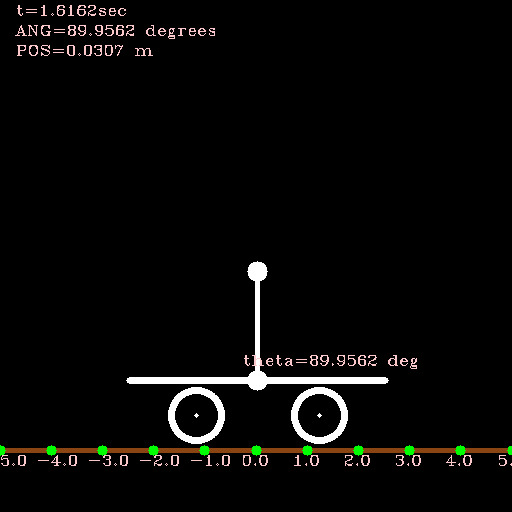

position    velocity    angle   angular velocity time
[0.029525509420175688, -0.005197810833360414, 1.5704697632011246, 0.0017102353274596142] 1.8181818181818181


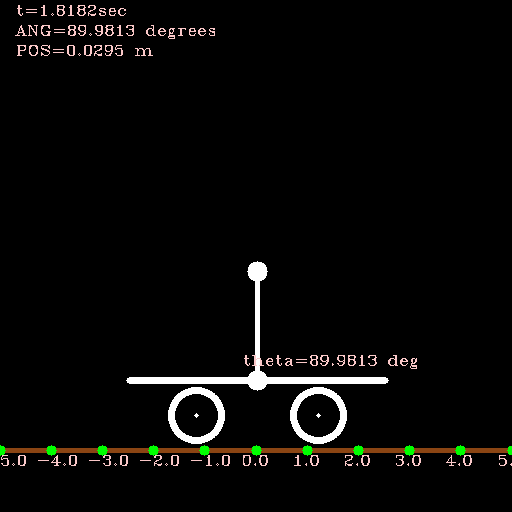

position    velocity    angle   angular velocity time
[0.02864092775469453, -0.0035560342064090214, 1.5707237674861656, 0.0008355579096408002] 2.0202020202020203


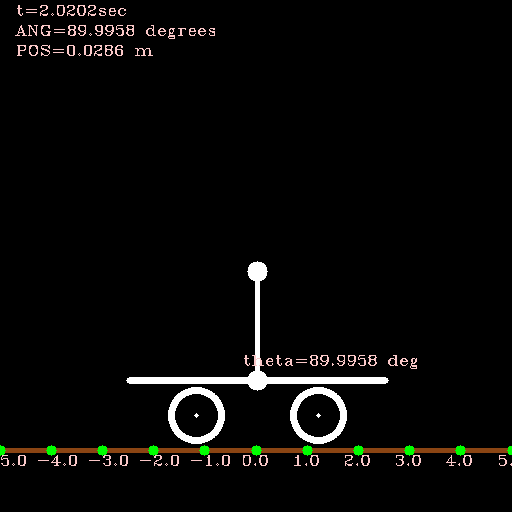

position    velocity    angle   angular velocity time
[0.02807226810605718, -0.002142779989927672, 1.5708243052293756, 0.00020546258048457505] 2.2222222222222223


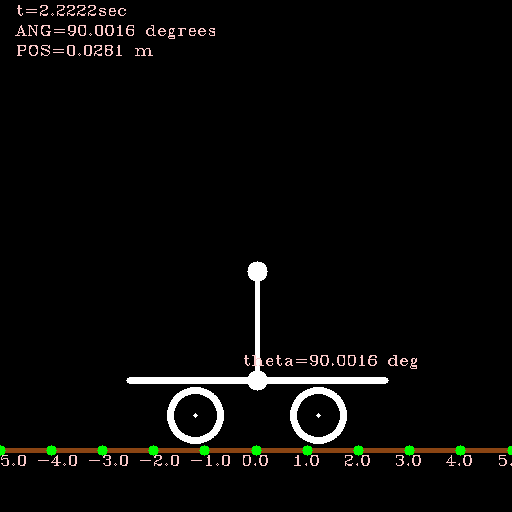

position    velocity    angle   angular velocity time
[0.027741254639449667, -0.0012286385630491782, 1.5708263283500967, -0.00013812017014659341] 2.4242424242424243


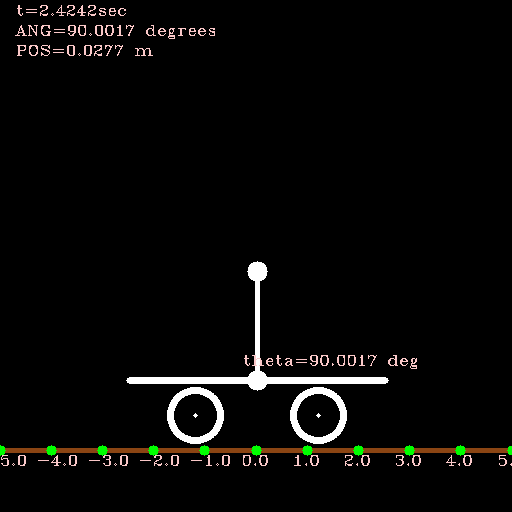

position    velocity    angle   angular velocity time
[0.027542618788351125, -0.0008043954135353393, 1.570783914001798, -0.0002536631016028891] 2.6262626262626263


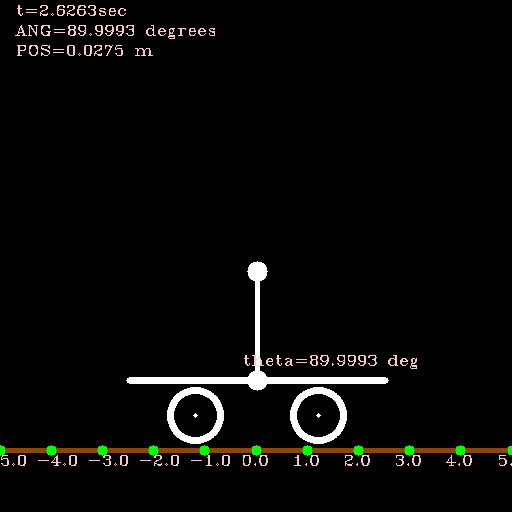

position    velocity    angle   angular velocity time
[0.02739242235877548, -0.0007244508441446268, 1.570733361089701, -0.00023184139955384999] 2.8282828282828283


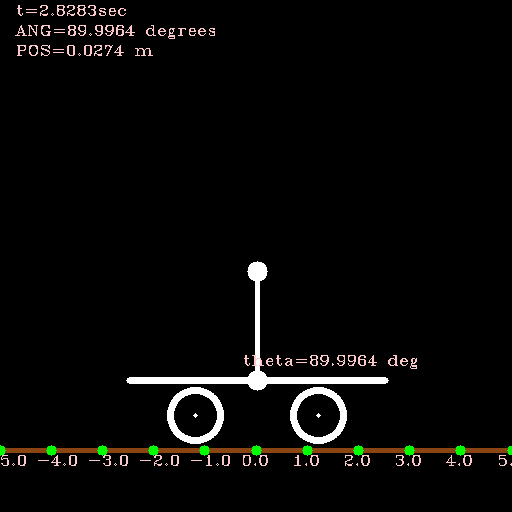

position    velocity    angle   angular velocity time
[0.027237631369999182, -0.0008246127053176512, 1.5706941194663662, -0.00015317350015928274] 3.0303030303030303


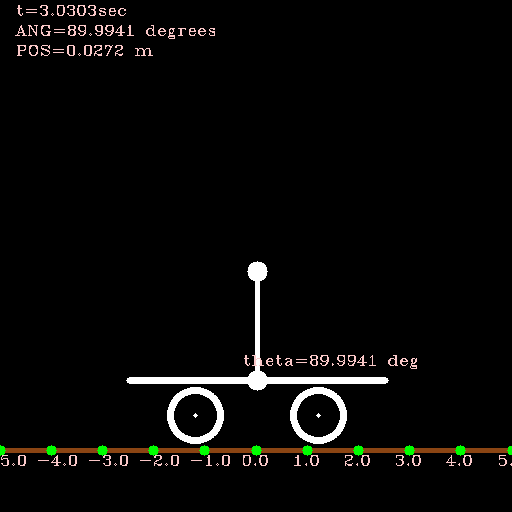

position    velocity    angle   angular velocity time
[0.027055767529707796, -0.0009757859079880964, 1.5706716848784996, -7.128498348732626e-05] 3.2323232323232323


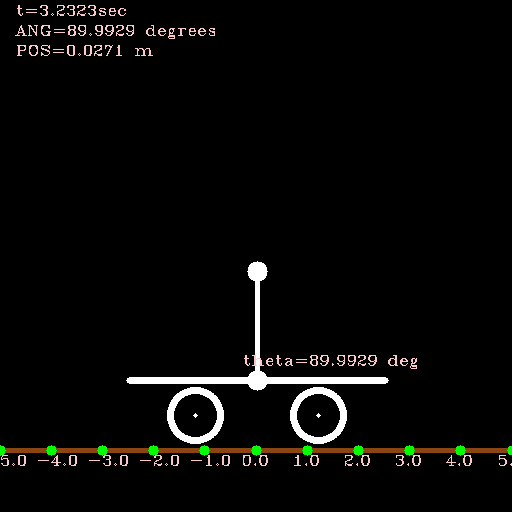

position    velocity    angle   angular velocity time
[0.02684445516462344, -0.0011060617281379624, 1.5706640081729426, -1.1113830103119977e-05] 3.4343434343434343


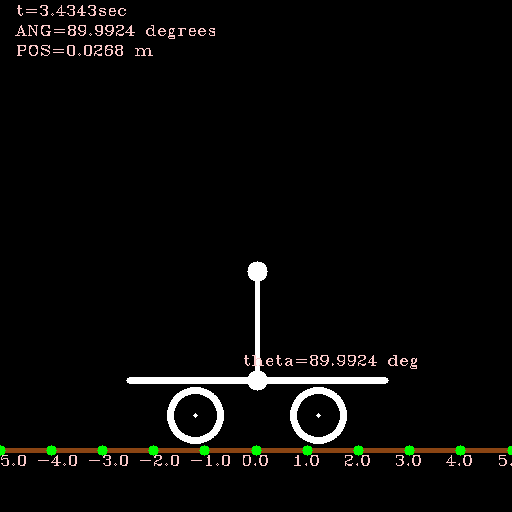

position    velocity    angle   angular velocity time
[0.026612377567603384, -0.0011848836431808101, 1.5706653370815369, 2.1450132147999906e-05] 3.6363636363636362


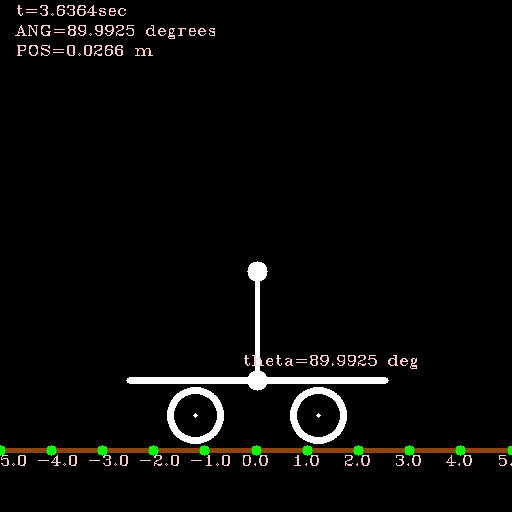

position    velocity    angle   angular velocity time
[0.026368888423030062, -0.0012150392514291813, 1.5706711336845025, 3.172999756939077e-05] 3.8383838383838382


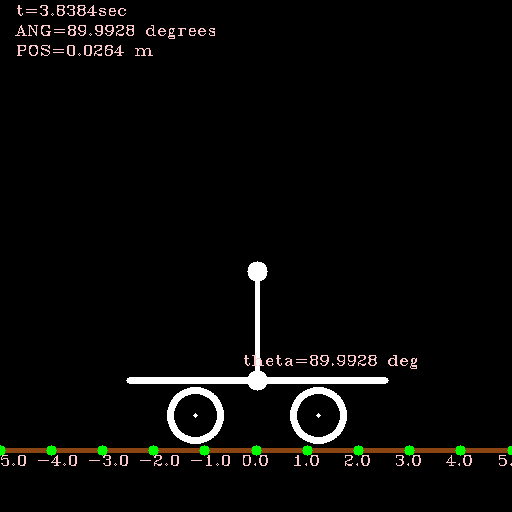

position    velocity    angle   angular velocity time
[0.02612306325571484, -0.0012113714310937728, 1.5706775370382904, 2.8918012341789845e-05] 4.040404040404041


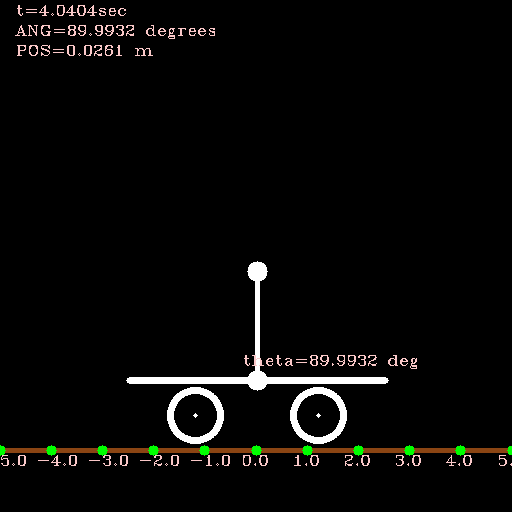

position    velocity    angle   angular velocity time
[0.025881045740477823, -0.0011921032491655418, 1.5706823132352168, 2.190262214294546e-05] 4.242424242424242


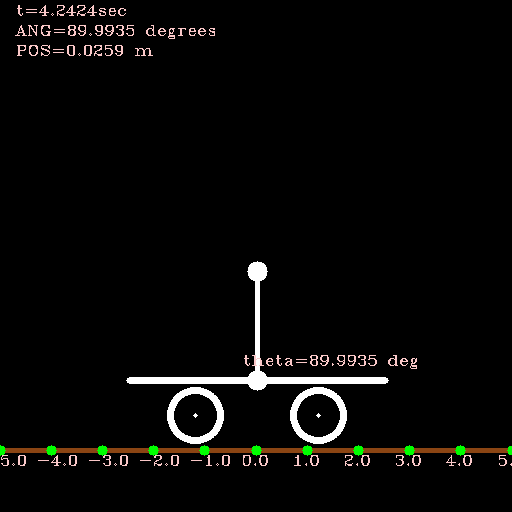

position    velocity    angle   angular velocity time
[0.025642893959238543, -0.0011655486036384669, 1.5706858303189375, 1.3380175882081191e-05] 4.444444444444445


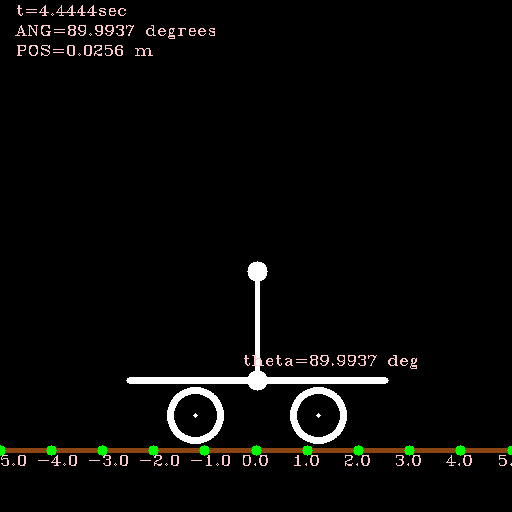

position    velocity    angle   angular velocity time
[0.025409943750686153, -0.0011413869323412995, 1.570687863497628, 7.151301646614e-06] 4.646464646464646


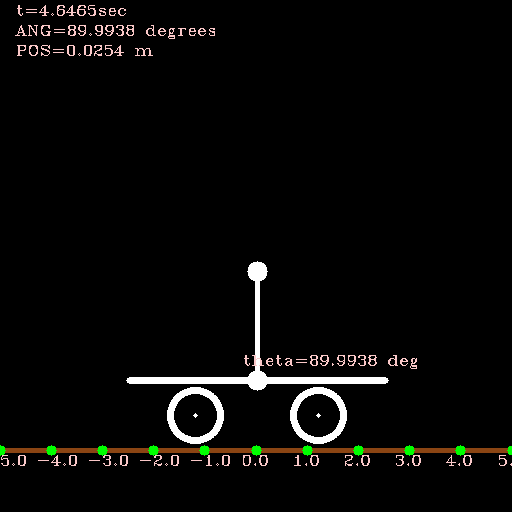

position    velocity    angle   angular velocity time
[0.02518146775197149, -0.001122226738681538, 1.5706888965976726, 3.7078756311161535e-06] 4.848484848484849


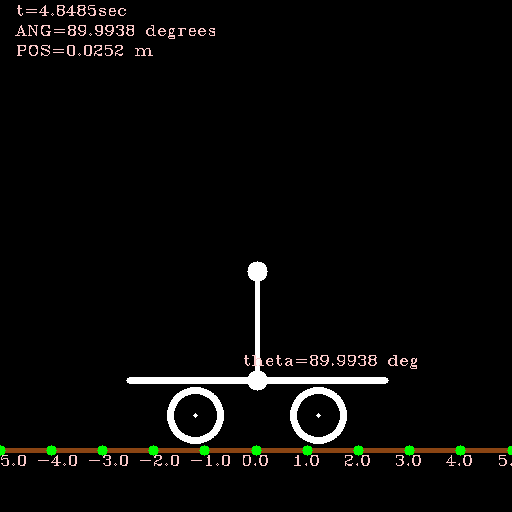

position    velocity    angle   angular velocity time
[0.024956945498360285, -0.0011080752864436165, 1.5706891856134797, 2.8005813605882534e-06] 5.05050505050505


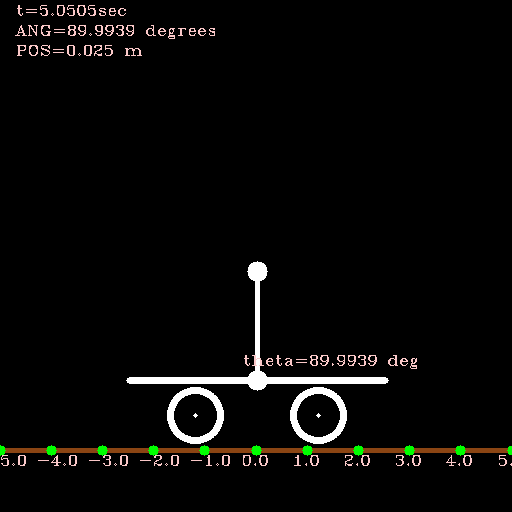

position    velocity    angle   angular velocity time
[0.02473439577450786, -0.0010974849516963054, 1.5706896513309914, 3.003255109806056e-06] 5.252525252525253


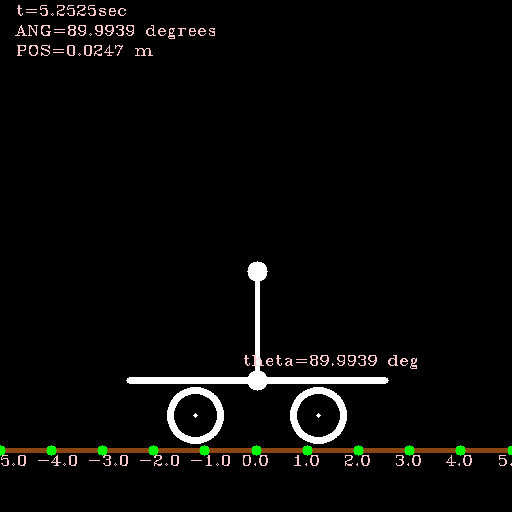

position    velocity    angle   angular velocity time
[0.024512922595471085, -0.0010882575283927124, 1.5706906330843673, 3.1729017294457477e-06] 5.454545454545454


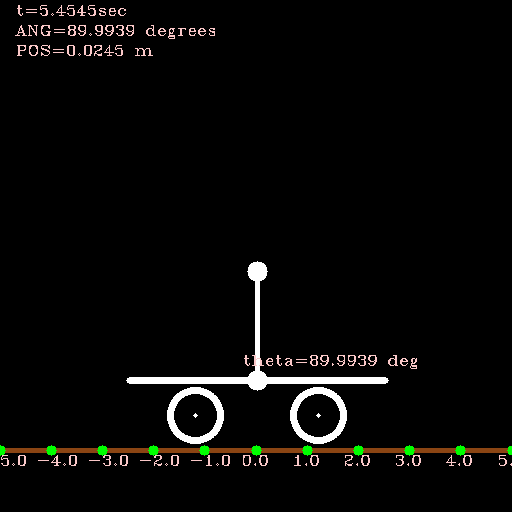

position    velocity    angle   angular velocity time
[0.02429354810676434, -0.0010788409725759039, 1.5706915352480693, 3.3083910752963458e-06] 5.656565656565657


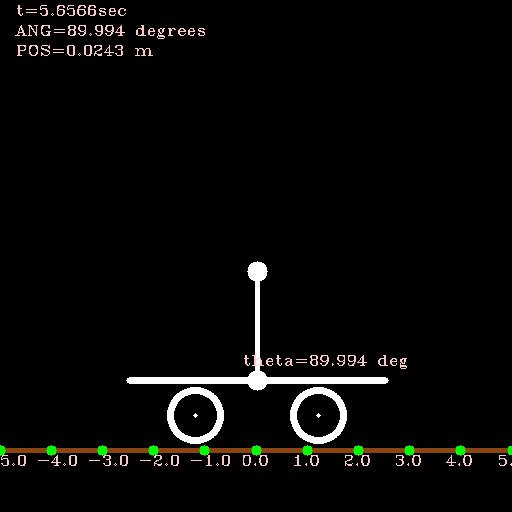

position    velocity    angle   angular velocity time
[0.02407663032217769, -0.0010701830111963593, 1.5706922133791115, 3.90064396537686e-06] 5.858585858585858


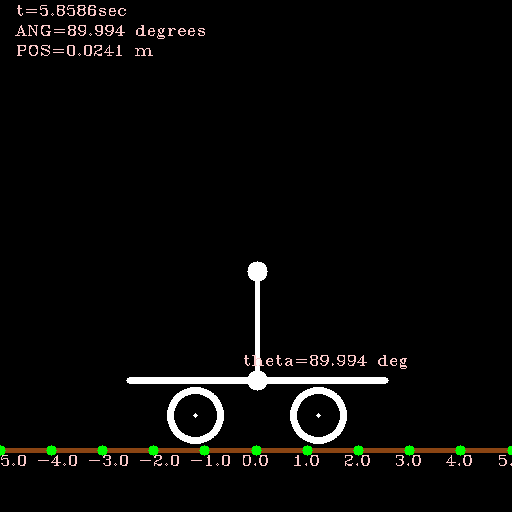

position    velocity    angle   angular velocity time
[0.023861373106161095, -0.0010614848106138633, 1.5706930215676715, 4.3128314041793775e-06] 6.0606060606060606


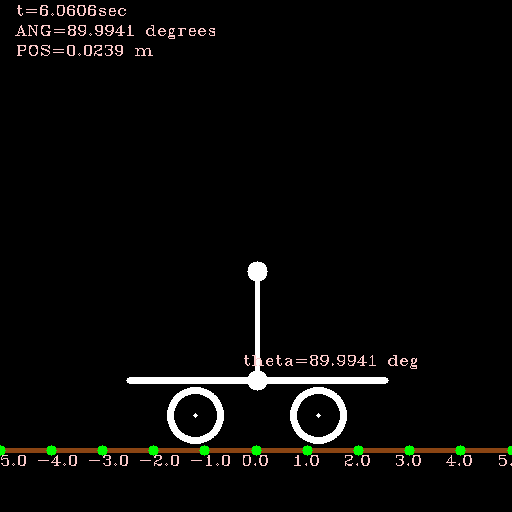

position    velocity    angle   angular velocity time
[0.023647704845677325, -0.001052069032500446, 1.5706939553436372, 4.298649771719733e-06] 6.262626262626262


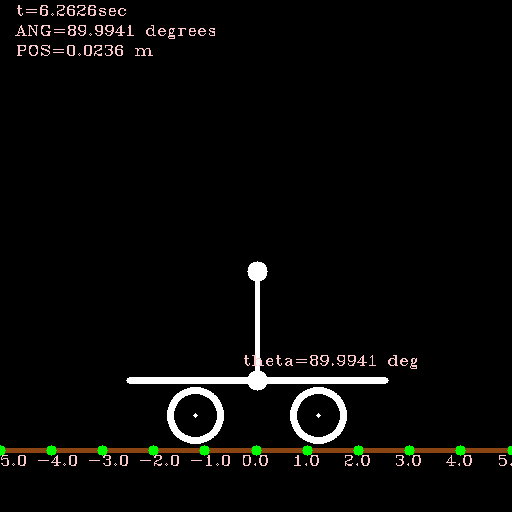

position    velocity    angle   angular velocity time
[0.023435984036311162, -0.0010428643059058106, 1.5706948695358633, 4.342306085629796e-06] 6.4646464646464645


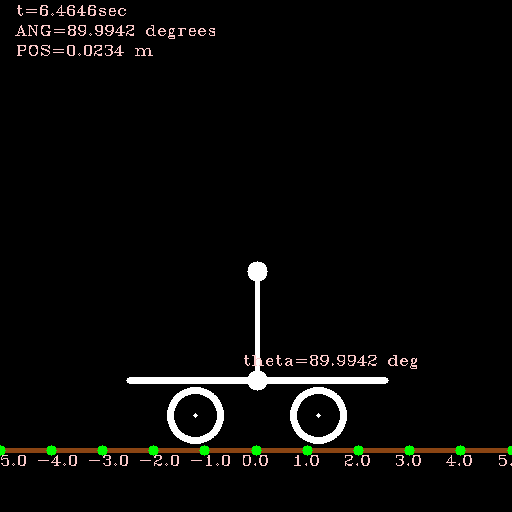

position    velocity    angle   angular velocity time
[0.023226163021964508, -0.0010341562980967446, 1.5706957931813905, 4.5217272254655854e-06] 6.666666666666667


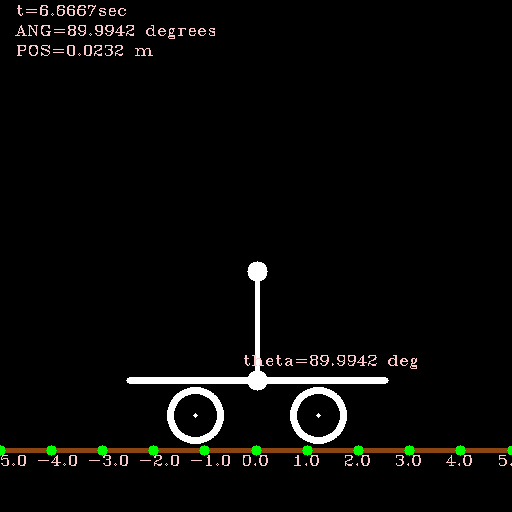

position    velocity    angle   angular velocity time
[0.023018155904772634, -0.0010251685644375424, 1.5706967243002445, 4.5519797133351415e-06] 6.8686868686868685


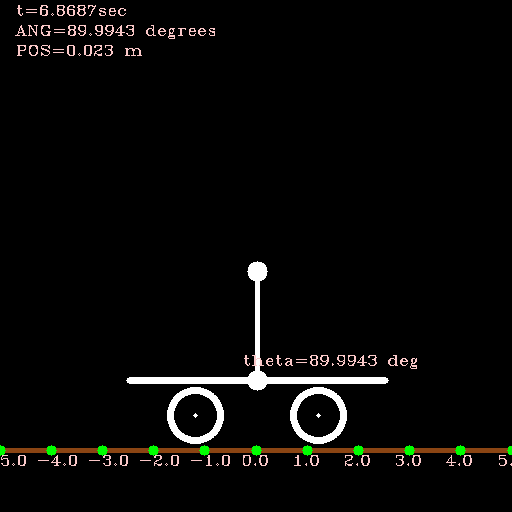

position    velocity    angle   angular velocity time
[0.022812022364351783, -0.0010157305076177552, 1.5706976163391329, 4.415380830389483e-06] 7.070707070707071


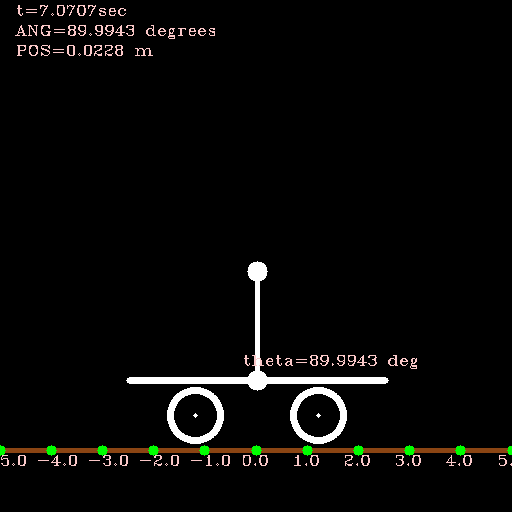

position    velocity    angle   angular velocity time
[0.02260778322688011, -0.001006166696123211, 1.5706984658819463, 4.235662520781006e-06] 7.2727272727272725


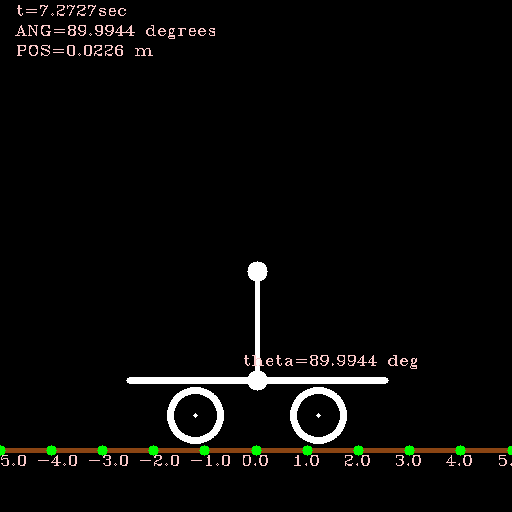

position    velocity    angle   angular velocity time
[0.02240537628666113, -0.0009974267832205154, 1.5706993410759604, 4.2985197639446326e-06] 7.474747474747475


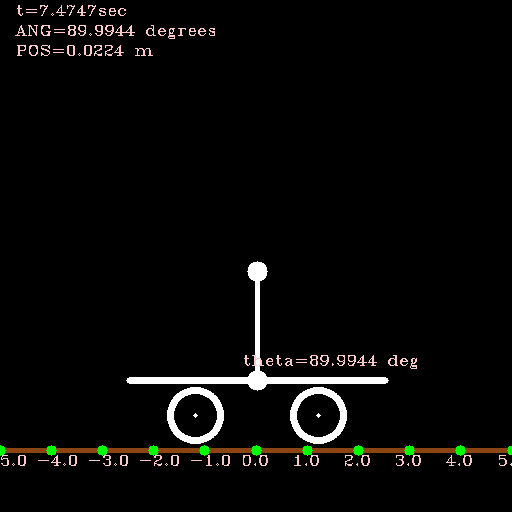

position    velocity    angle   angular velocity time
[0.022203899735235892, -0.000992262736816072, 1.5707008188221592, 5.063870292323728e-06] 7.6767676767676765


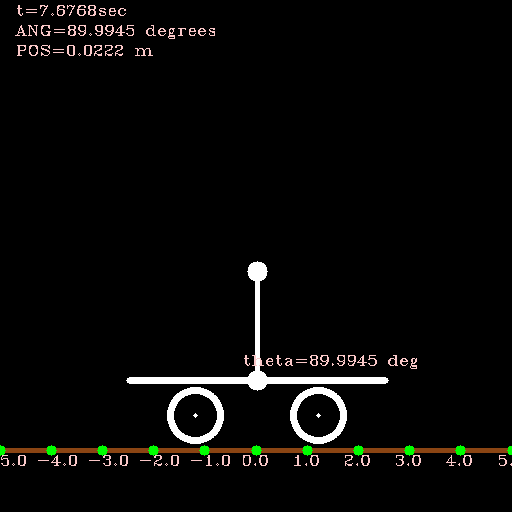

position    velocity    angle   angular velocity time
[0.02200368367788944, -0.000987777635261103, 1.5707025874684335, 5.761758391387287e-06] 7.878787878787879


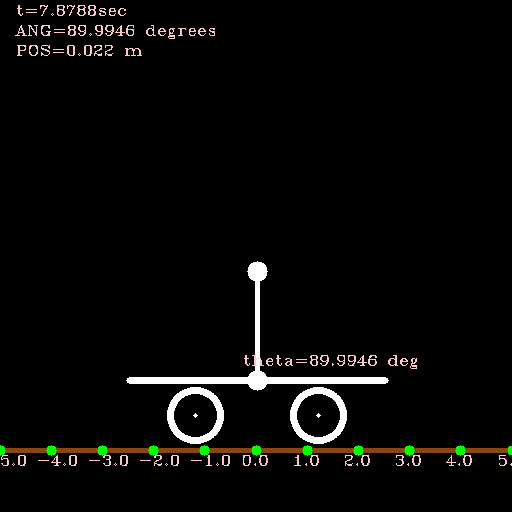

position    velocity    angle   angular velocity time
[0.021805440412023654, -0.0009805767082798154, 1.5707041191238638, 5.647482552394258e-06] 8.080808080808081


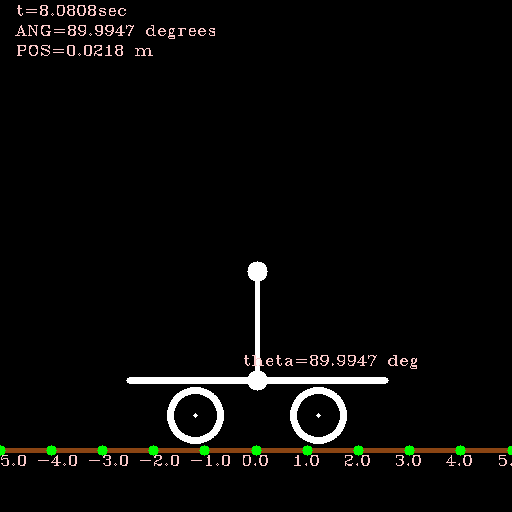

position    velocity    angle   angular velocity time
[0.02160965607300464, -0.0009689994021181432, 1.5707050820768533, 4.428186999424036e-06] 8.282828282828282


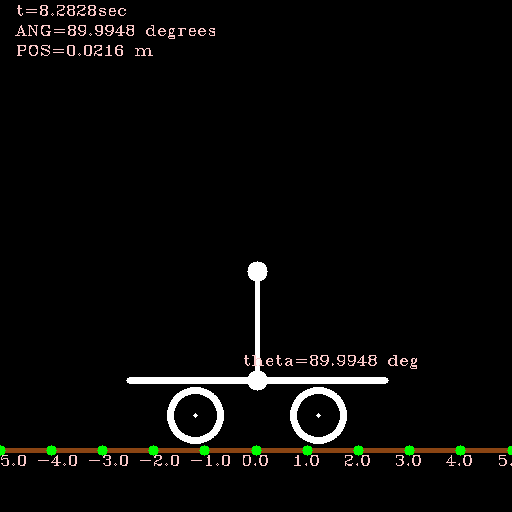

position    velocity    angle   angular velocity time
[0.02141659063416271, -0.0009531193795437476, 1.570705340795128, 2.262861689376404e-06] 8.484848484848484


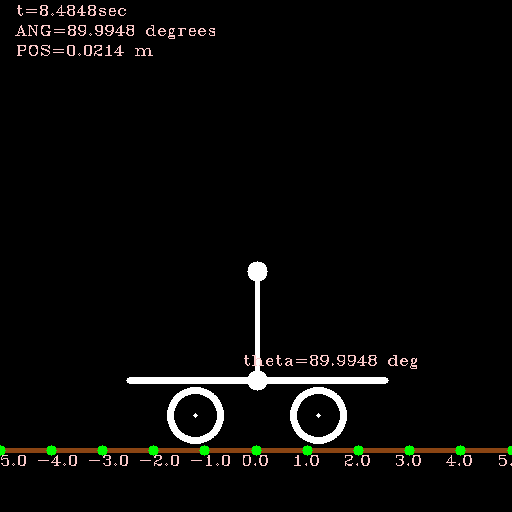

position    velocity    angle   angular velocity time
[0.021226277906792414, -0.0009347445198460171, 1.5707049559257364, -2.3765768802839096e-07] 8.686868686868687


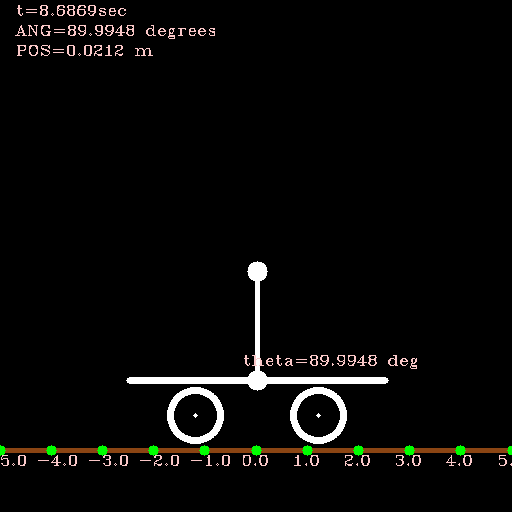

position    velocity    angle   angular velocity time
[0.02103852554015251, -0.0009174169188360679, 1.5707041842950502, -2.0106897102496945e-06] 8.88888888888889


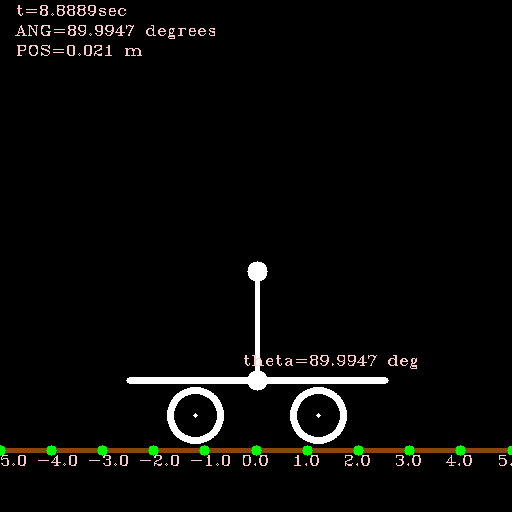

position    velocity    angle   angular velocity time
[0.020852915021465978, -0.0009064128888467432, 1.5707034789087628, -1.5417072219264277e-06] 9.09090909090909


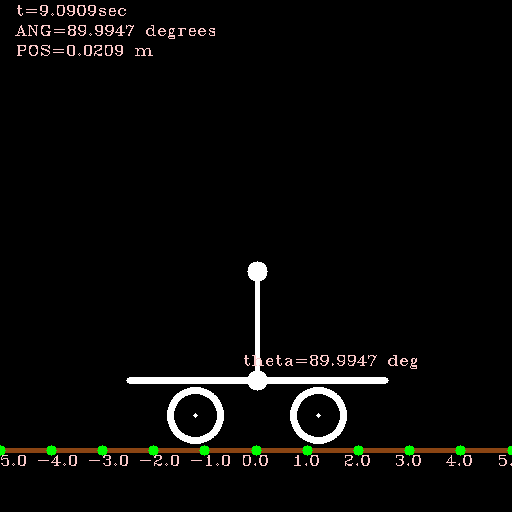

position    velocity    angle   angular velocity time
[0.020668801675920015, -0.000908742958732613, 1.5707034889518916, 3.1356626651229637e-06] 9.292929292929292


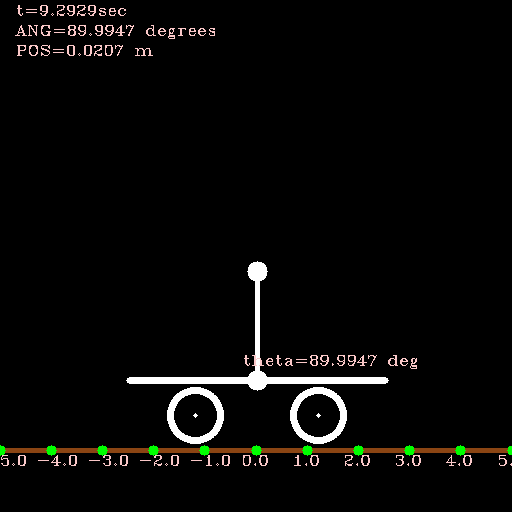

position    velocity    angle   angular velocity time
[0.02048382759192276, -0.0009152656514226474, 1.5707049636985257, 7.911629117693117e-06] 9.494949494949495


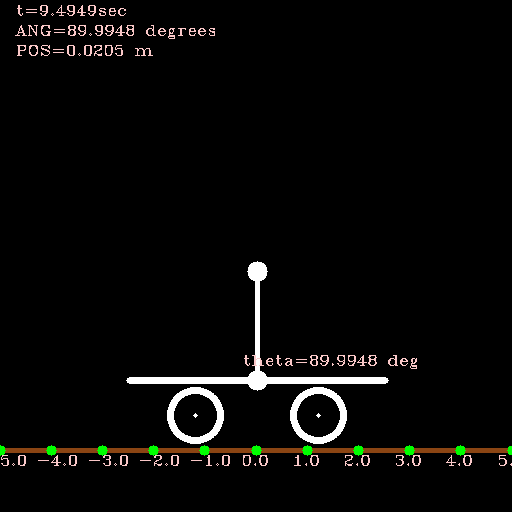

position    velocity    angle   angular velocity time
[0.020298896058960552, -0.000912585274971945, 1.5707068066921763, 8.889743942639106e-06] 9.696969696969697


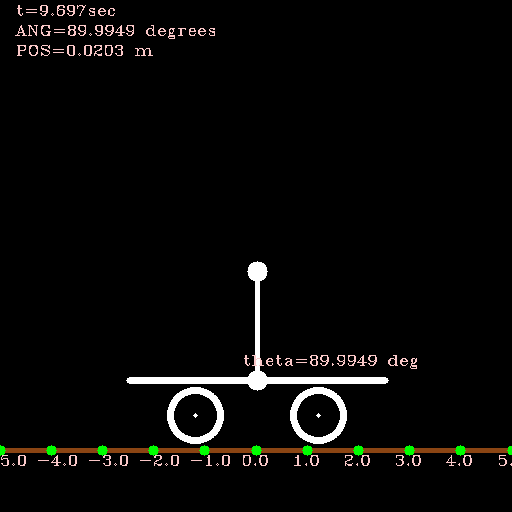

position    velocity    angle   angular velocity time
[0.020115990646839915, -0.0009045615587325288, 1.5707081928411692, 8.298425956783662e-06] 9.8989898989899


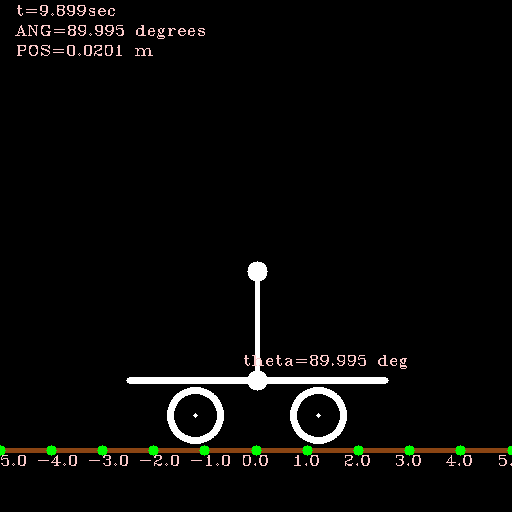

position    velocity    angle   angular velocity time
[0.019934388495236308, -0.0008946102852793489, 1.5707096408601597, 6.899996674392512e-06] 10.1010101010101


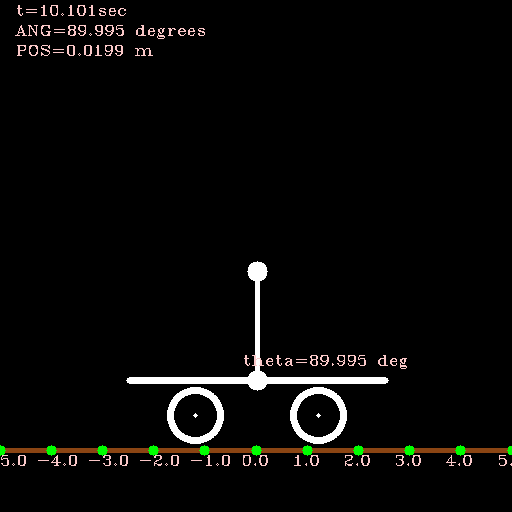

position    velocity    angle   angular velocity time
[0.019754658564382636, -0.0008835496456284572, 1.5707108952145143, 5.2453118833432936e-06] 10.303030303030303


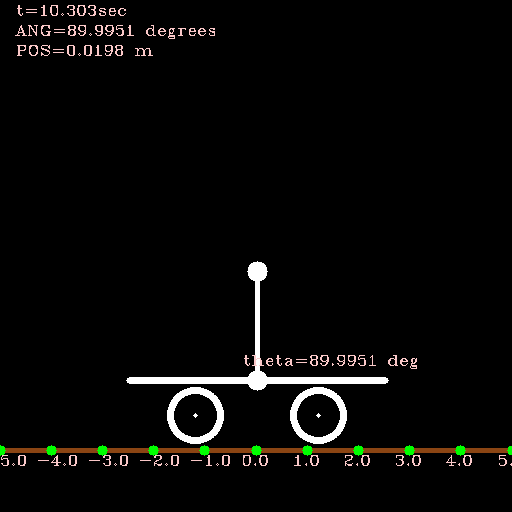

position    velocity    angle   angular velocity time
[0.0195772535587678, -0.0008737348878479899, 1.5707118316065378, 4.327355906078385e-06] 10.505050505050505


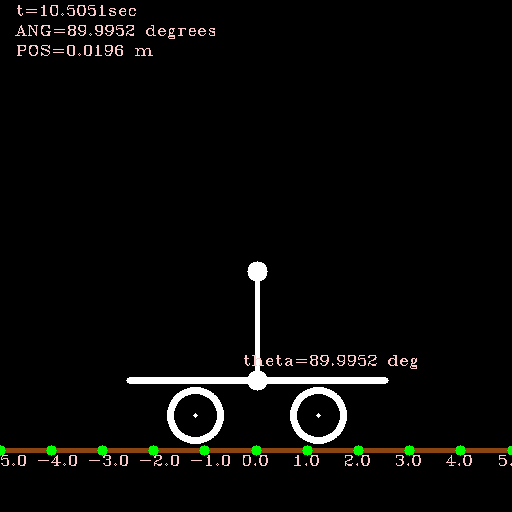

position    velocity    angle   angular velocity time
[0.019401798062946535, -0.0008646989495032426, 1.5707126101978082, 3.818245260276656e-06] 10.707070707070708


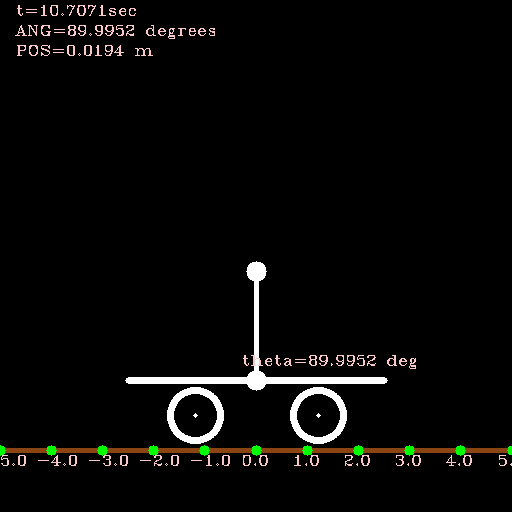

position    velocity    angle   angular velocity time
[0.019228152181220433, -0.0008558585498575022, 1.5707132669664519, 3.467347198782557e-06] 10.909090909090908


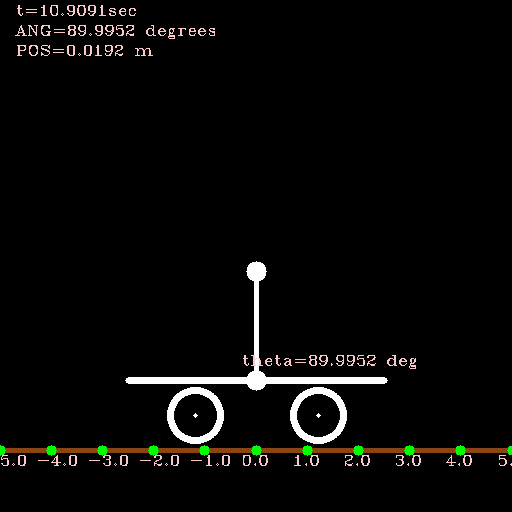

position    velocity    angle   angular velocity time
[0.01905614846405326, -0.0008478645244059743, 1.5707139100272332, 3.4113451776409254e-06] 11.11111111111111


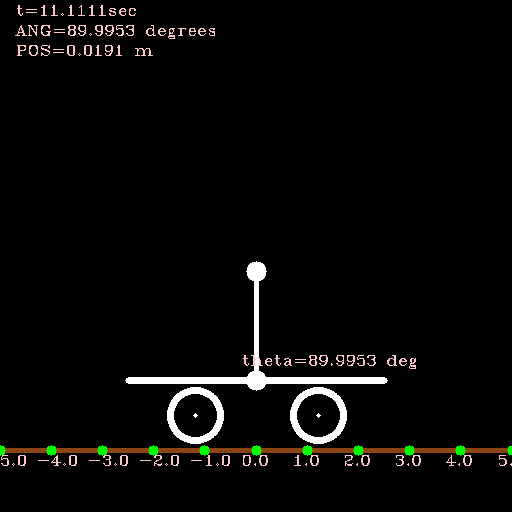

position    velocity    angle   angular velocity time
[0.01888551681333179, -0.0008404527657744066, 1.5707146561522407, 3.439641877734144e-06] 11.313131313131313


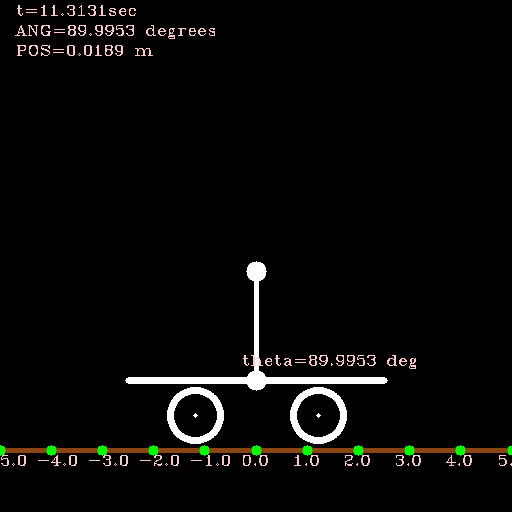

position    velocity    angle   angular velocity time
[0.018716317620797607, -0.0008330954231584624, 1.570715443129088, 3.4172403931184927e-06] 11.515151515151516


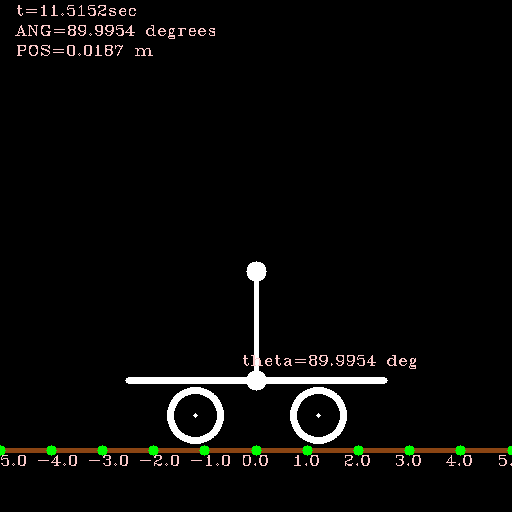

position    velocity    angle   angular velocity time
[0.018548896689708994, -0.0008256689187582778, 1.5707160840008172, 3.47964626070008e-06] 11.717171717171716


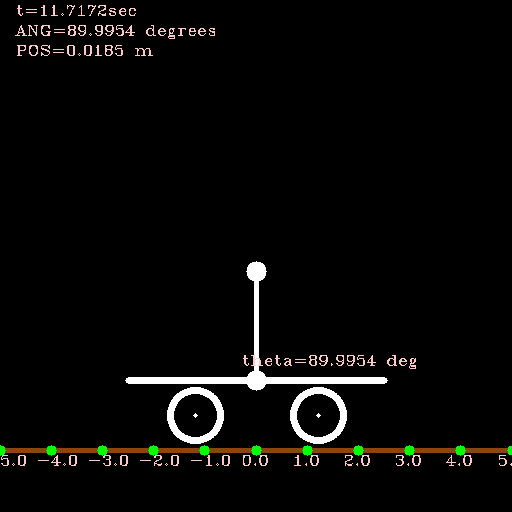

position    velocity    angle   angular velocity time
[0.018383131685194398, -0.0008187966108175217, 1.5707166630970475, 3.7763708736204043e-06] 11.919191919191919


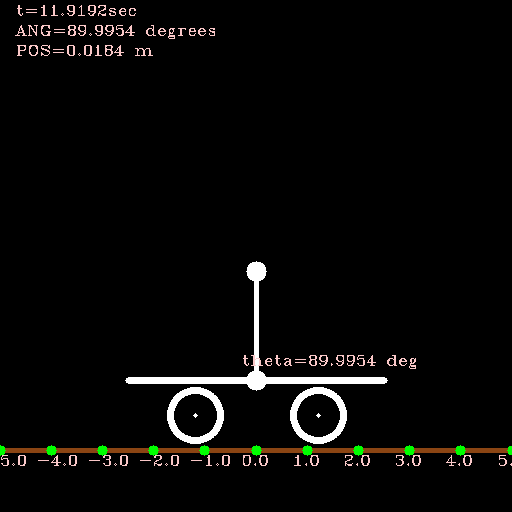

position    velocity    angle   angular velocity time
[0.018218620088519266, -0.0008117931078473609, 1.570717344303135, 3.895182927909044e-06] 12.121212121212121


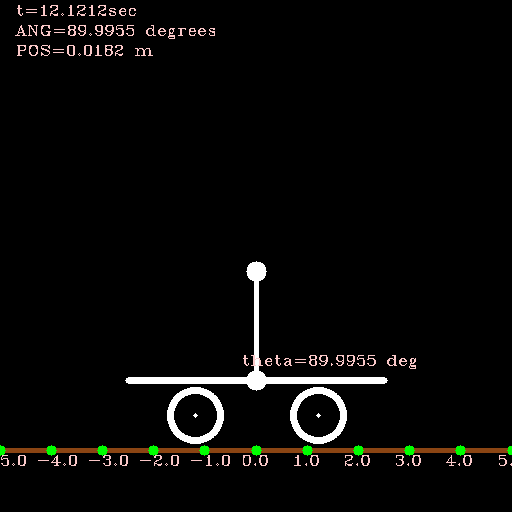

position    velocity    angle   angular velocity time
[0.01805523152108894, -0.000804312755264884, 1.5707181704065416, 3.666914058985183e-06] 12.323232323232324


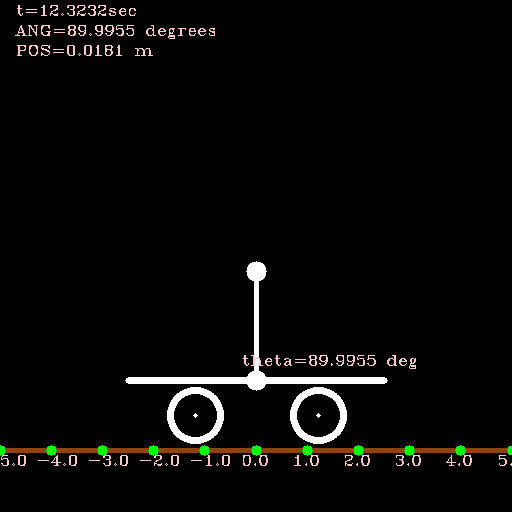

position    velocity    angle   angular velocity time
[0.01789311712540079, -0.0007964224380600383, 1.5707190618026032, 3.1936757041170942e-06] 12.525252525252524


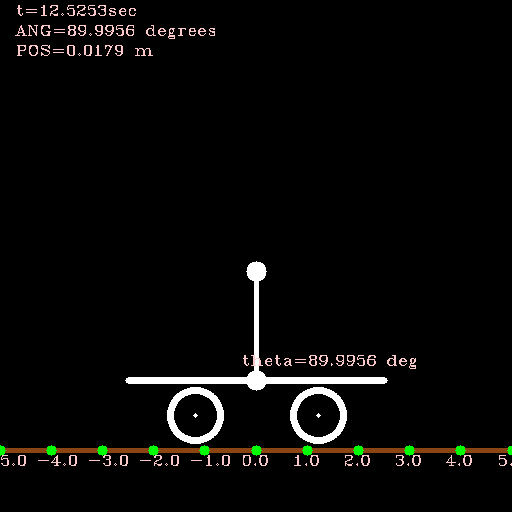

position    velocity    angle   angular velocity time
[0.017732709565044205, -0.0007886015807956294, 1.570719816494529, 2.848859102422117e-06] 12.727272727272727


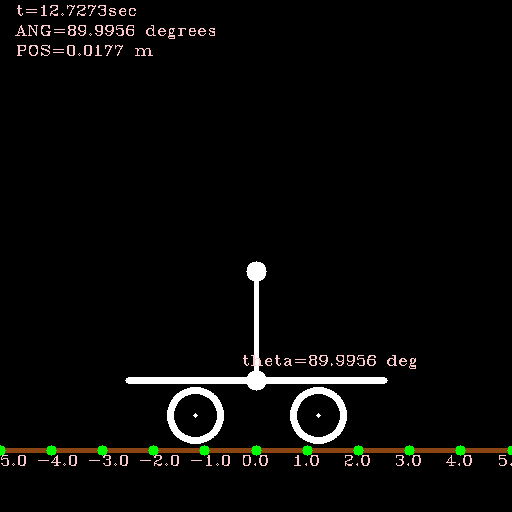

position    velocity    angle   angular velocity time
[0.017574346259248967, -0.000781987714717082, 1.5707203116091035, 3.1729875312625765e-06] 12.929292929292929


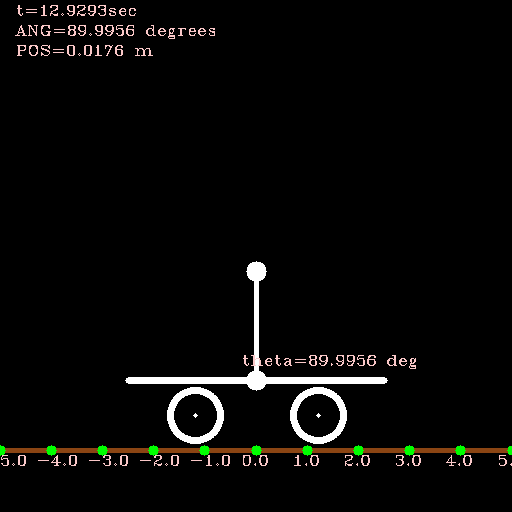

position    velocity    angle   angular velocity time
[0.01741738923456778, -0.0007759152771347462, 1.5707208309601073, 3.6450436571074894e-06] 13.131313131313131


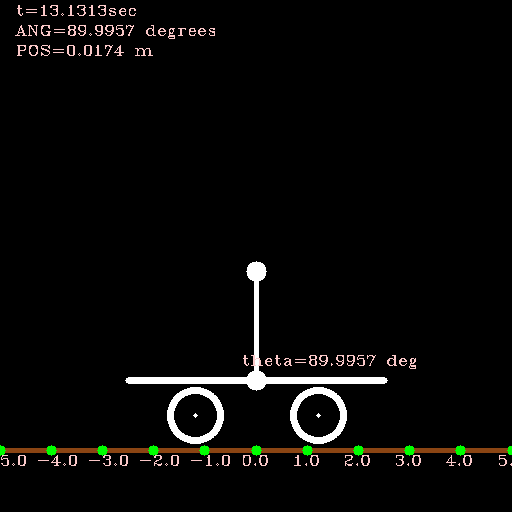

position    velocity    angle   angular velocity time
[0.01726138779262752, -0.0007691099900146029, 1.570721535289243, 3.637717196824461e-06] 13.333333333333334


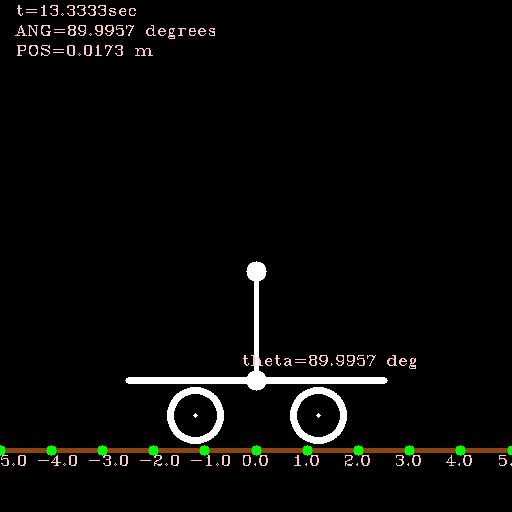

position    velocity    angle   angular velocity time
[0.017106367581702808, -0.000761357504449627, 1.570722395271438, 3.1002753523429464e-06] 13.535353535353535


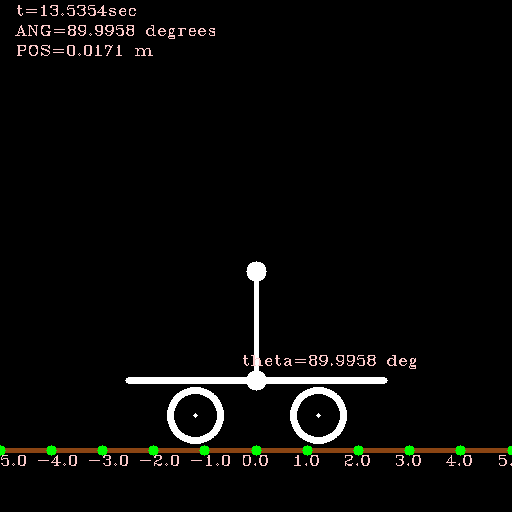

position    velocity    angle   angular velocity time
[0.01695283053550991, -0.0007535041626523134, 1.5707231915816524, 2.5587803484109675e-06] 13.737373737373737


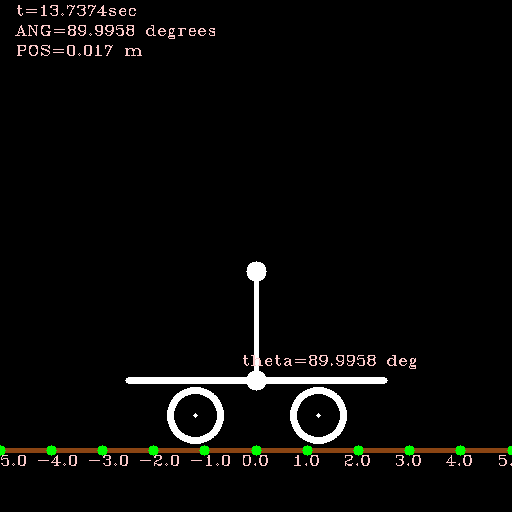

position    velocity    angle   angular velocity time
[0.01680139656889414, -0.0007472340508608914, 1.5707236850064399, 2.868810247472111e-06] 13.93939393939394


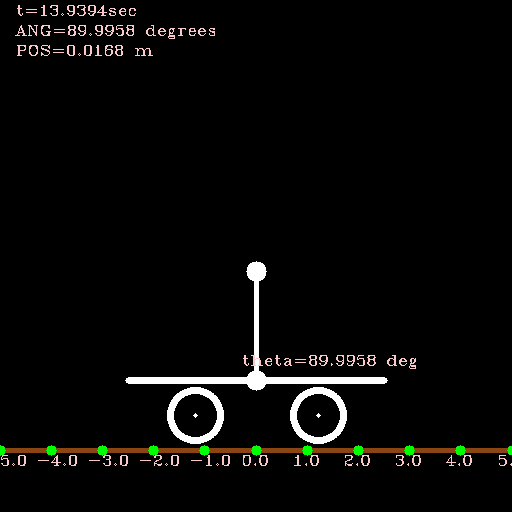

position    velocity    angle   angular velocity time
[0.016651408245530058, -0.0007418649228610764, 1.57072416867423, 3.49412133539089e-06] 14.141414141414142


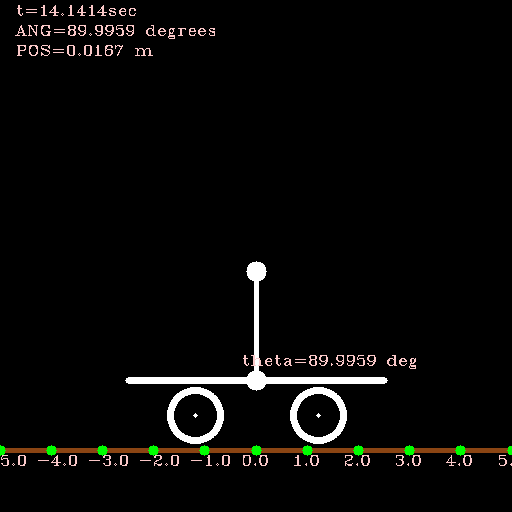

position    velocity    angle   angular velocity time
[0.016502350598723674, -0.0007355978754838784, 1.5707248112487338, 3.6054229279503795e-06] 14.343434343434343


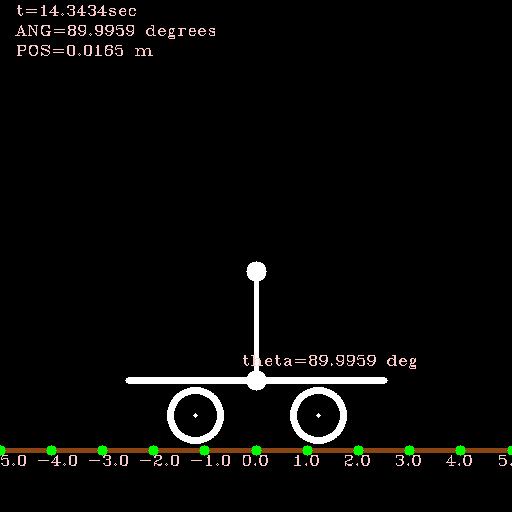

position    velocity    angle   angular velocity time
[0.016354182388392036, -0.0007280016923944126, 1.5707256071666789, 3.048647666749036e-06] 14.545454545454545


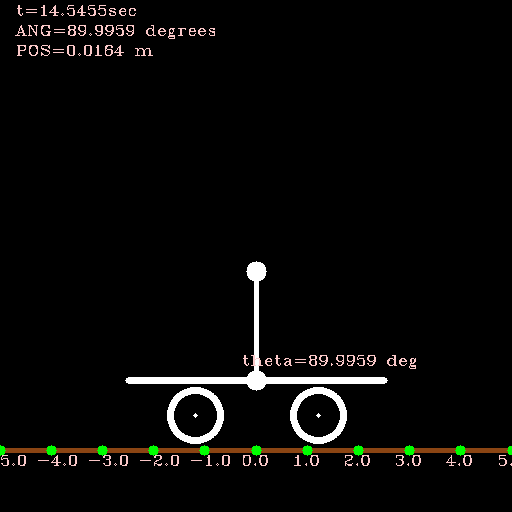

position    velocity    angle   angular velocity time
[0.016207321289160744, -0.0007200534045178995, 1.5707263860189784, 2.350889978050082e-06] 14.747474747474747


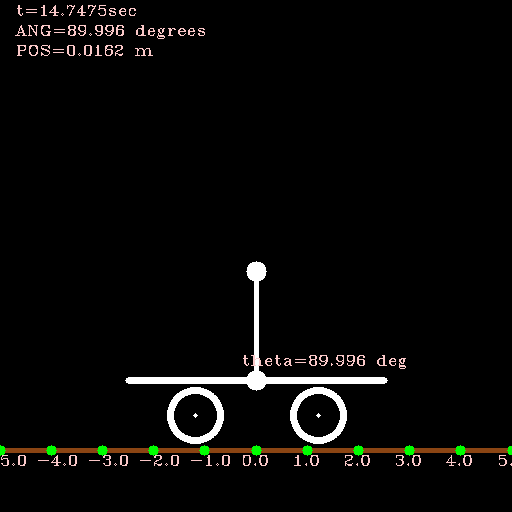

position    velocity    angle   angular velocity time
[0.01606246833661874, -0.0007139435967597099, 1.5707268918668518, 2.5715001495842794e-06] 14.94949494949495


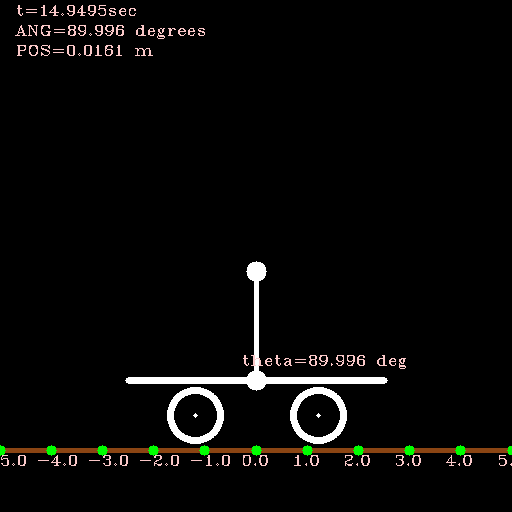

position    velocity    angle   angular velocity time
[0.015919120625667464, -0.0007093260982111017, 1.5707273560671722, 3.3584919177263027e-06] 15.15151515151515


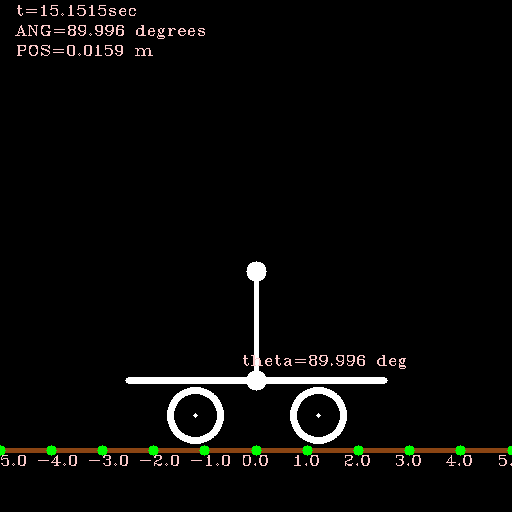

position    velocity    angle   angular velocity time
[0.015776696170041633, -0.0007037670096572916, 1.5707279513711427, 3.64343260176518e-06] 15.353535353535353


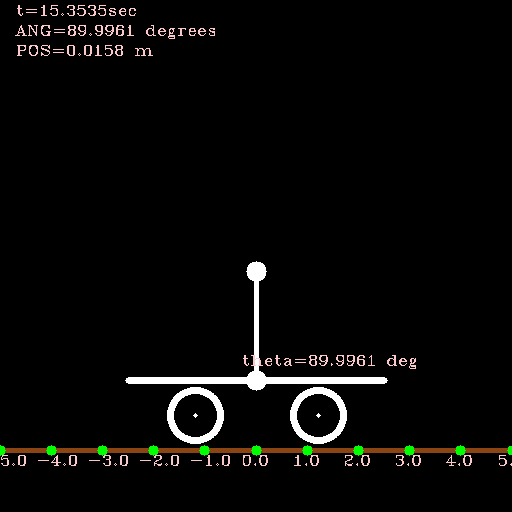

position    velocity    angle   angular velocity time
[0.015635087737751904, -0.0006964214775986234, 1.5707286862278778, 3.105485627913628e-06] 15.555555555555555


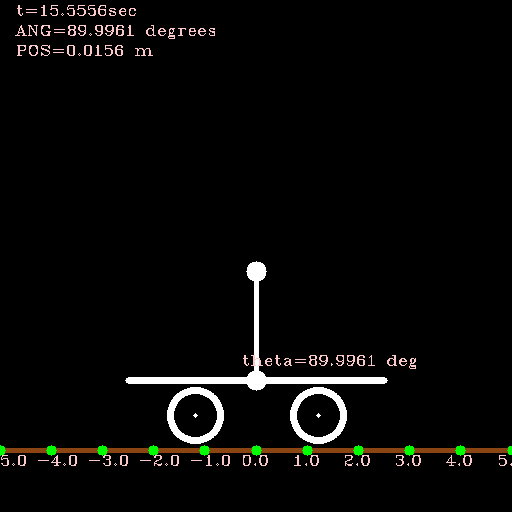

position    velocity    angle   angular velocity time
[0.01549460736375252, -0.0006881793209137978, 1.5707294396304525, 2.1916024243228926e-06] 15.757575757575758


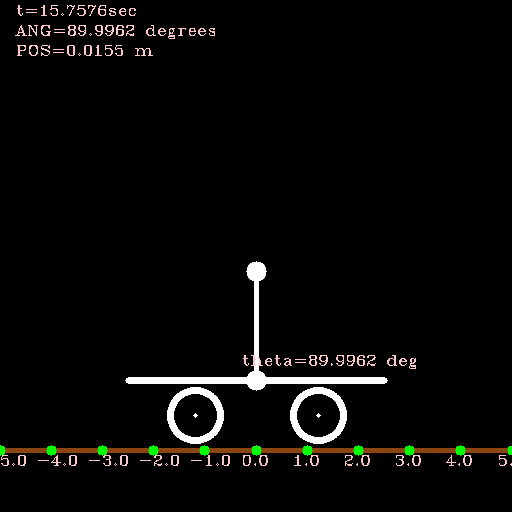

position    velocity    angle   angular velocity time
[0.015355961588382108, -0.0006816351906974558, 1.570729972191163, 2.094746771097353e-06] 15.959595959595958


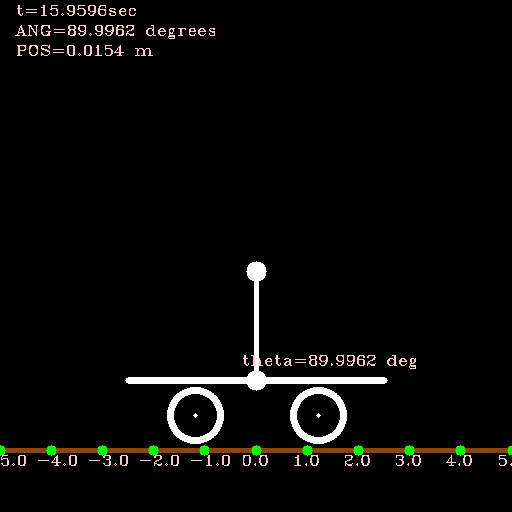

position    velocity    angle   angular velocity time
[0.015218969915079076, -0.0006777328430467482, 1.5707304138608245, 3.0388346994705545e-06] 16.161616161616163


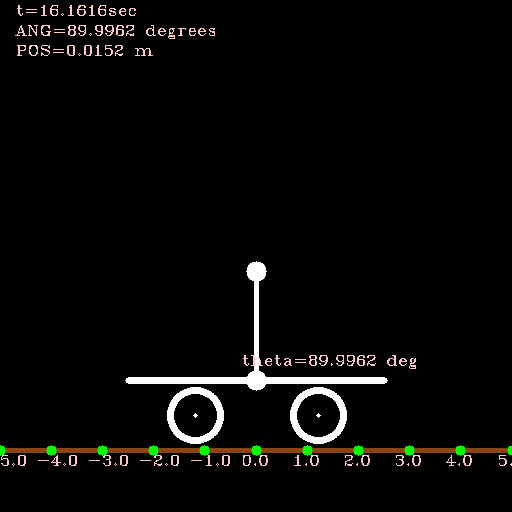

position    velocity    angle   angular velocity time
[0.015082911434061536, -0.0006732493029877662, 1.5707309704451007, 3.6311792849376133e-06] 16.363636363636363


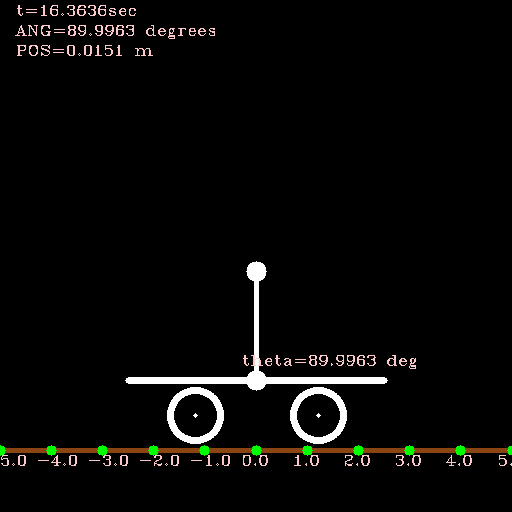

position    velocity    angle   angular velocity time
[0.014947621730059505, -0.0006665271140227217, 1.5707316411245769, 3.2589606733607696e-06] 16.565656565656564


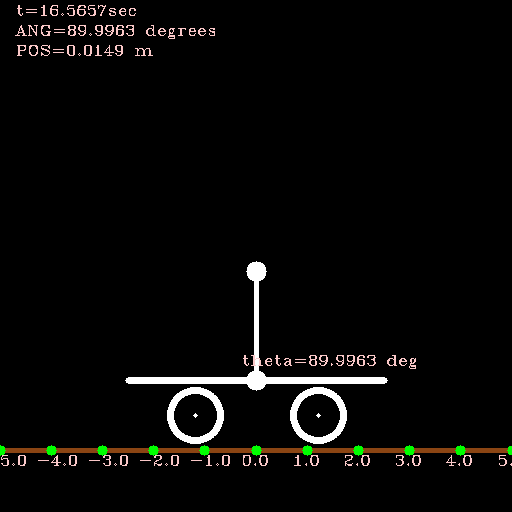

position    velocity    angle   angular velocity time
[0.014813309079706658, -0.0006580909825939994, 1.5707323402205429, 2.1996929295881026e-06] 16.767676767676768


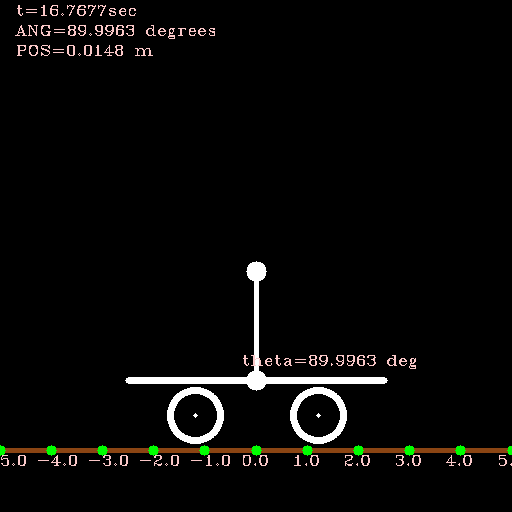

position    velocity    angle   angular velocity time
[0.01468055445154034, -0.0006506477780841574, 1.570732897194993, 1.6212240374536358e-06] 16.96969696969697


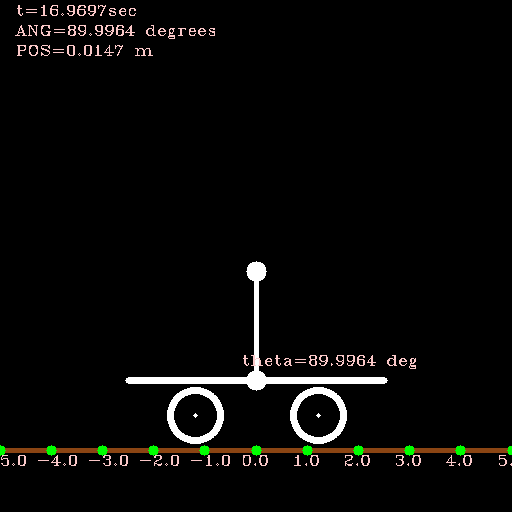

position    velocity    angle   angular velocity time
[0.014549607317521725, -0.0006470207472280555, 1.5707333141762507, 2.5673025658549225e-06] 17.171717171717173


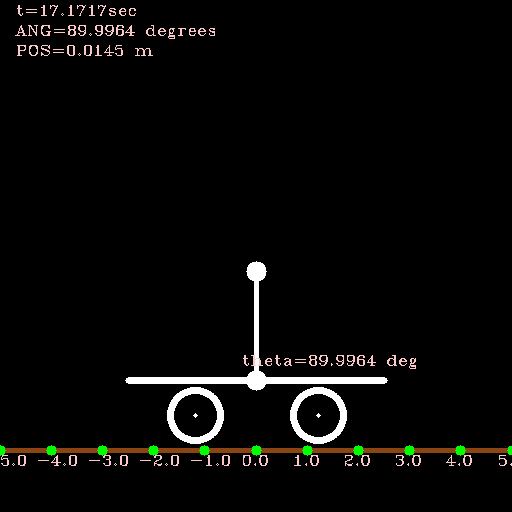

position    velocity    angle   angular velocity time
[0.014419566751259242, -0.0006436989442387615, 1.570733874380073, 3.463620584204969e-06] 17.373737373737374


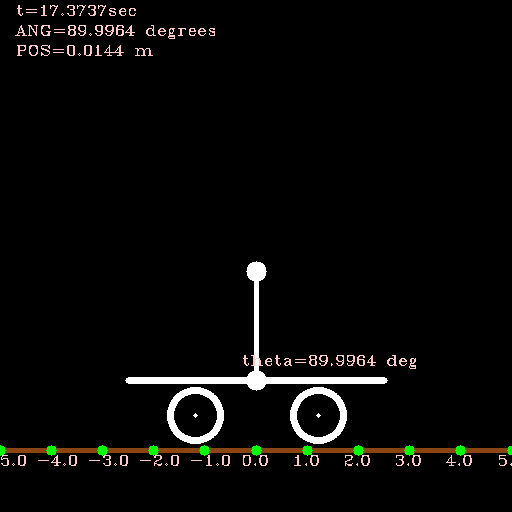

position    velocity    angle   angular velocity time
[0.014290313714511359, -0.0006379828965430302, 1.5707345051742732, 3.3809753241391164e-06] 17.575757575757574


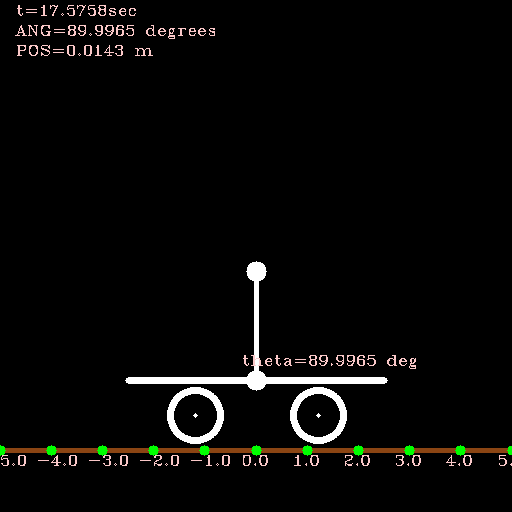

position    velocity    angle   angular velocity time
[0.014161998445210414, -0.0006297697258675292, 1.570735120761042, 2.3645606738686744e-06] 17.77777777777778


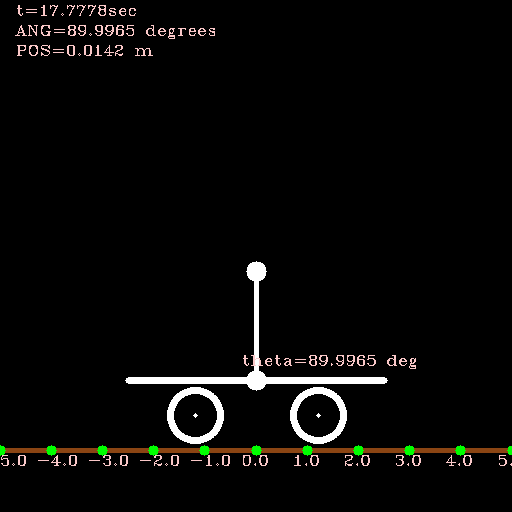

position    velocity    angle   angular velocity time
[0.014035022769955949, -0.0006215322913591366, 1.5707356301098367, 1.4185611938523212e-06] 17.97979797979798


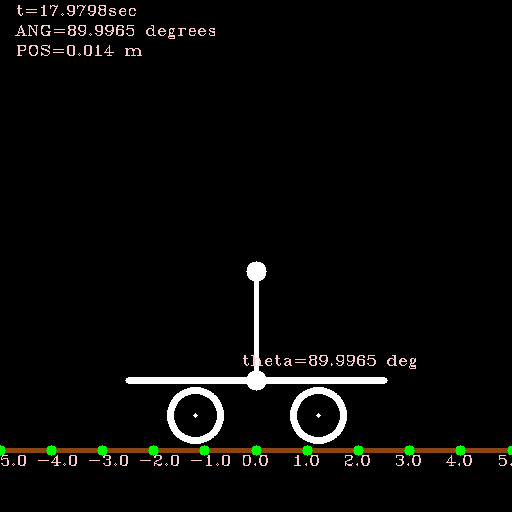

position    velocity    angle   angular velocity time
[0.013909786421932366, -0.0006175243866248613, 1.5707360273422313, 2.124273788139948e-06] 18.18181818181818


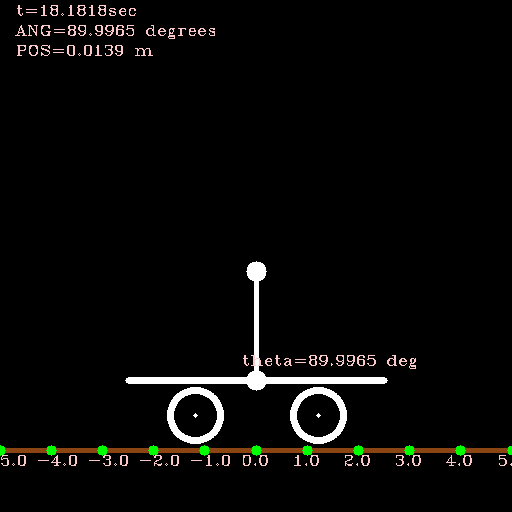

position    velocity    angle   angular velocity time
[0.013785373403463209, -0.0006153072936151797, 1.5707366541092906, 3.2478938356619626e-06] 18.383838383838384


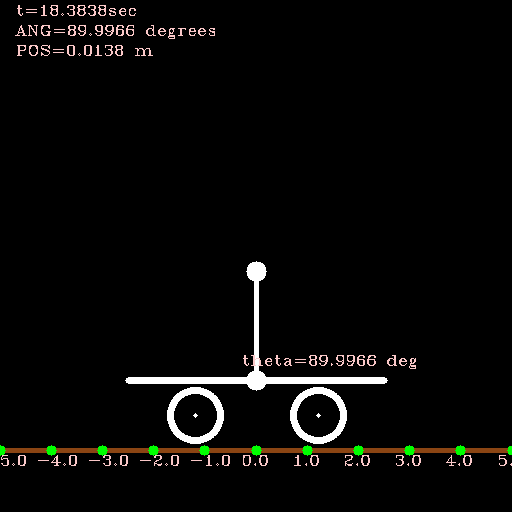

position    velocity    angle   angular velocity time
[0.013661762966913949, -0.000610825400778642, 1.570737324453797, 3.4676981940278914e-06] 18.585858585858585


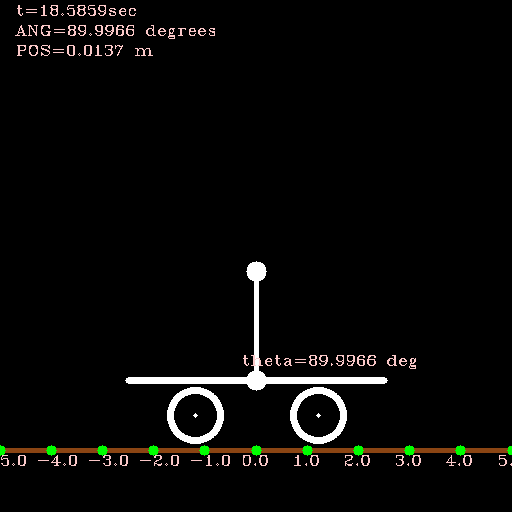

position    velocity    angle   angular velocity time
[0.01353918412233811, -0.0006030967355364146, 1.5707378716048044, 2.5817073967627074e-06] 18.78787878787879


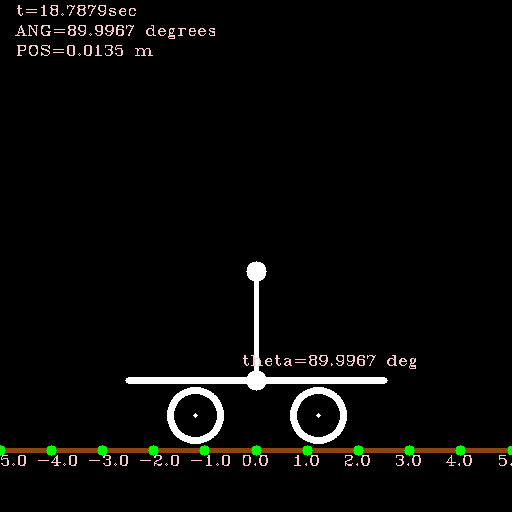

position    velocity    angle   angular velocity time
[0.013417899884335092, -0.0005940322009704187, 1.5707382482196453, 1.343672229109083e-06] 18.98989898989899


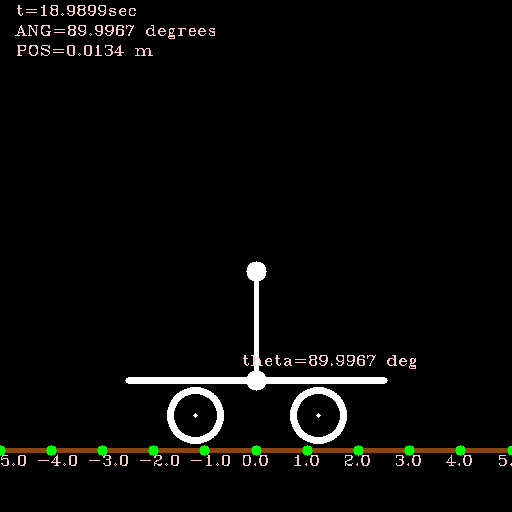

position    velocity    angle   angular velocity time
[0.013298204350214577, -0.0005884189797221419, 1.5707385270737497, 1.456259373870601e-06] 19.19191919191919


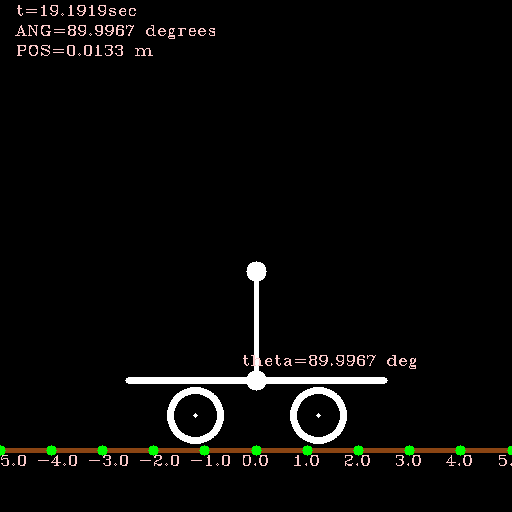

position    velocity    angle   angular velocity time
[0.013179472697650883, -0.0005859817245540632, 1.5707390053425465, 2.529927268950088e-06] 19.393939393939394


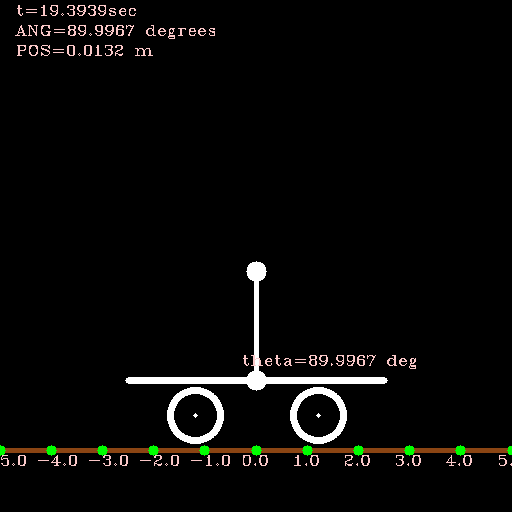

position    velocity    angle   angular velocity time
[0.013061430635031455, -0.0005821615978294648, 1.5707396013657102, 2.9555785815354864e-06] 19.595959595959595


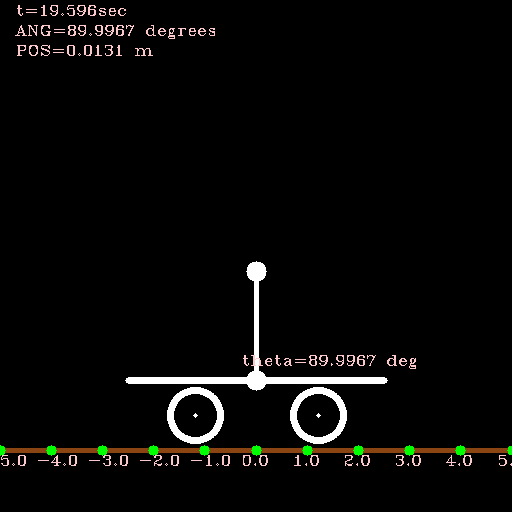

position    velocity    angle   angular velocity time
[0.012944415132168617, -0.0005768761772210946, 1.5707401366160585, 2.8757578927613397e-06] 19.7979797979798


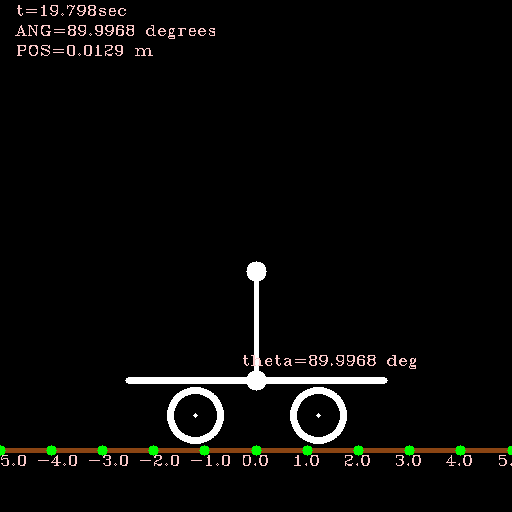

position    velocity    angle   angular velocity time
[0.01282847818912637, -0.0005714852824611276, 1.5707406443438814, 2.762072075478643e-06] 20.0


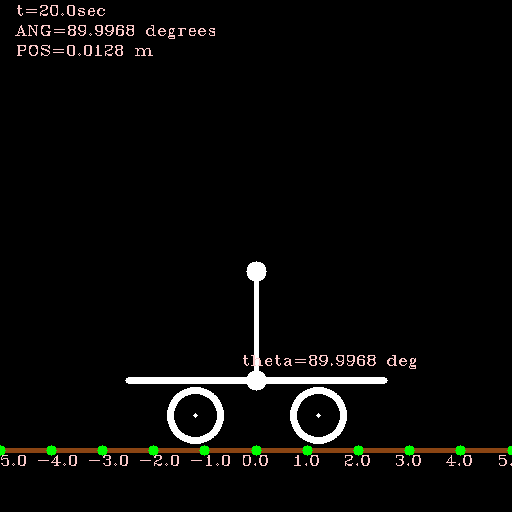

In [14]:
from google.colab.patches import cv2_imshow
for i, t in enumerate(sol.t):
        print('position','  ','velocity','  ','angle',' ','angular velocity', 'time')
        print( [sol.y[0,i], sol.y[1,i], sol.y[2,i], sol.y[3,i] ], t)
        rendered = syst.step( [sol.y[0,i], sol.y[1,i], sol.y[2,i], sol.y[3,i] ], t )
        cv2_imshow( rendered )
        #cv2.moveWindow( 'im', 100, 100 )

In the next cell we enable the user to inspect our system at a particular instant of time of their choice.

Enter a time instant to inspect the state.0.4


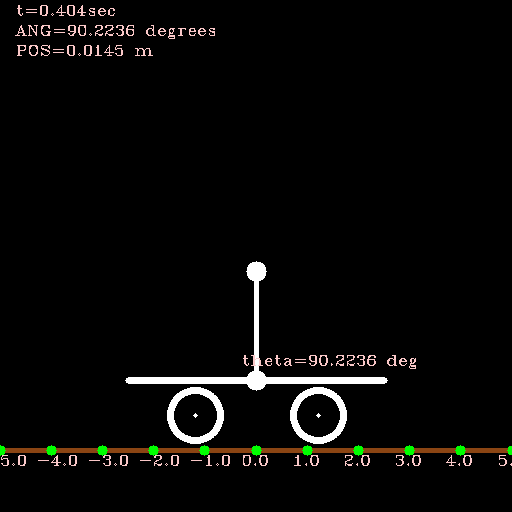

In [17]:
m=float(input('Enter a time instant to inspect the state. (any instant between 0 sec. and 20 sec. with intervals of 0.2 sec.'))
m=int(m*10)
moment=sol.t
a=0
for i in range(len(moment)):
  if(int(moment[i]*10)==m):
    a=i
    break
rendered = syst.step( [sol.y[0,a], sol.y[1,a], sol.y[2,a], sol.y[3,a] ], moment[a])
cv2_imshow( rendered )
